##Imports

In [1]:
import glob
import cv2
import math
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

##Loading and visualisation of training data

In [2]:
vehicle_data = np.array( glob.glob("./data/vehicles/**/*.png") )
non_vehicle_data = np.array( glob.glob("./data/non-vehicles/**/*.png") )
print('Vehicles loaded: {0}'.format(len(vehicle_data)))
print('Non-vehicles loaded: {0}'.format(len(non_vehicle_data)))

Vehicles loaded: 8792
Non-vehicles loaded: 8968


In [3]:
def visualise_images(images):
    fig, axs = plt.subplots(
        nrows=math.ceil(len(images) / 5),
        ncols=5,
        figsize=(16,16)
    )
    axs = axs.ravel()
    
    for image, ax in zip(images, axs):
        ax.imshow(image)

def load_images(images_paths):
    return [
        cv2.cvtColor(
            cv2.imread(image_path),
            cv2.COLOR_BGR2RGB
        )
        for image_path in images_paths
    ]

def sample(images, sample_size):
    return images[ np.random.choice(np.arange(len(images)), sample_size) ]

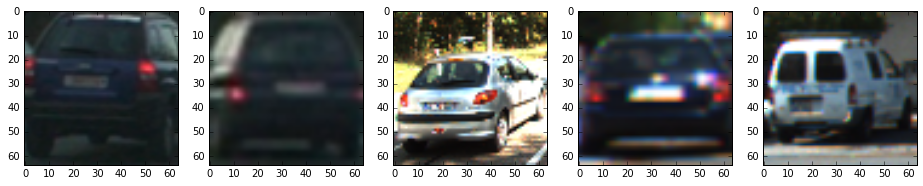

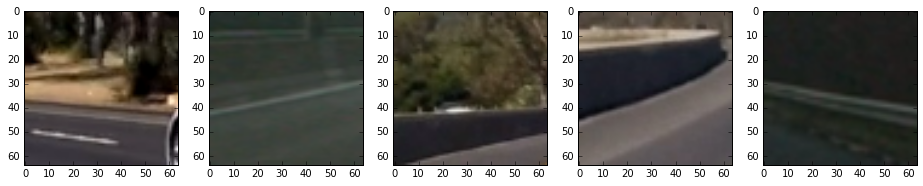

In [4]:
visualise_images(load_images(sample(vehicle_data, 5)))
visualise_images(load_images(sample(non_vehicle_data, 5)))

##Histogram of Gradients

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  # block_norm= 'L2-Hys', 
                                  transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    if type(return_list) != tuple:
        return return_list
    
    # name returns explicitly
    hog_features = return_list[0]
    
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

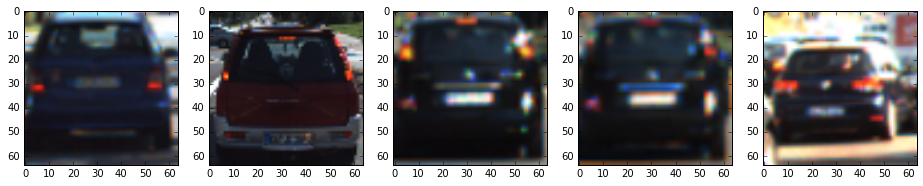

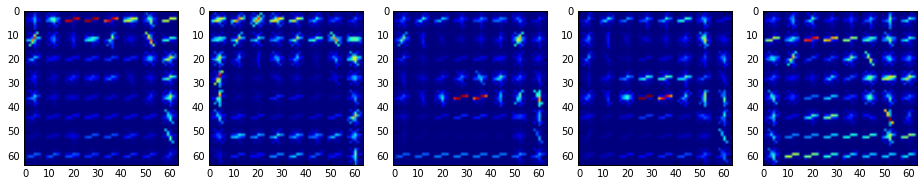

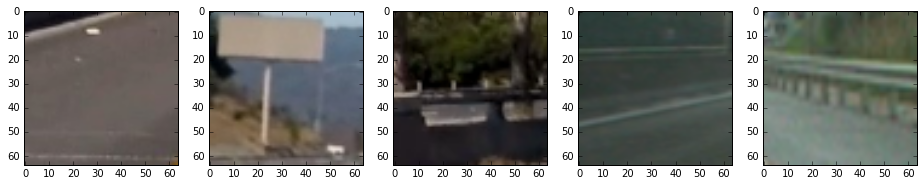

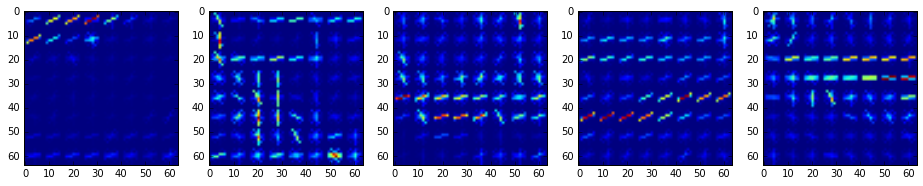

In [6]:
def visualise_hog(images_paths, sample_size):
    images_sample = sample(images_paths, sample_size)
    hog_images_sample = [
        get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)[1]
        for img in load_images(images_sample)
    ]
    
    visualise_images(load_images(images_sample))
    visualise_images(hog_images_sample)
    
visualise_hog(vehicle_data, 5)
visualise_hog(non_vehicle_data, 5)

##Features extraction and classisicator training

In [54]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 660] # Min and max in y to search in slide_window()

In [55]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  # block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       # block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

##Adapted from lessons

In [58]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

cars = vehicle_data
notcars = non_vehicle_data

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872


38.54 Seconds to train SVC...


Test Accuracy of SVC =  0.9901


In [60]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                windows.append( ( (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart) ) ) 
                
    # return draw_img
    return windows

In [61]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def draw_heated_boxes(image, box_list):
    
    # Read in image similar to one shown above 
    # image = mpimg.imread('./test_images/test6.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

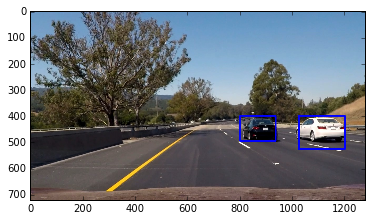

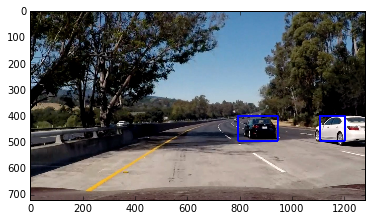

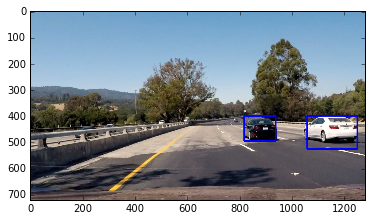

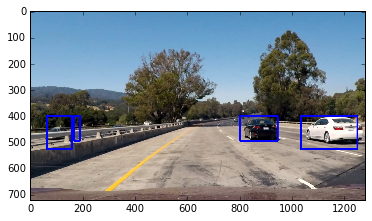

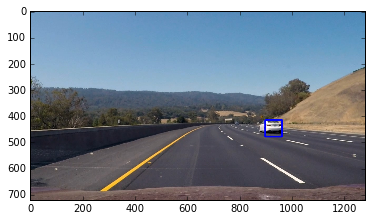

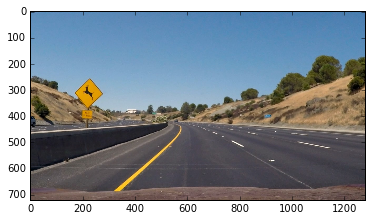

In [62]:
test_images_paths = glob.glob('./test_images/*.jpg')
# image = mpimg.imread('./test_images/test1.jpg')

def detect_vehicles(img):
    windows_params = [
        (350, 414, 1.0),
        (360, 424, 1.0),
        (400, 464, 1.0),
        (416, 480, 1.0),
        (400, 496, 1.5),
        (432, 528, 1.5),
        (400, 528, 2.0),
        (432, 560, 2.0),
        (400, 596, 3.5),
        (464, 660, 3.5),
    ]
    
    windows = [
        window
        for ystart, ystop, scale in windows_params
        for window in find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ]
    
    # ystart = 400
    # ystop = 656
    # scale = 1.5
    
    # windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img = draw_heated_boxes(img, windows)
    return out_img

for image_path in test_images_paths:
    
    img = mpimg.imread(image_path)
    out_img = detect_vehicles(img)
    
    plt.figure()
    plt.imshow(out_img)

##Video

In [28]:
from moviepy.editor import VideoFileClip
white_output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("test_video.mp4")

white_clip = clip1.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_video.mp4


[MoviePy] Writing video ./output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<21:09,  1.01s/it]

  0%|          | 2/1261 [00:02<21:19,  1.02s/it]

  0%|          | 3/1261 [00:03<20:56,  1.00it/s]

  0%|          | 4/1261 [00:03<20:28,  1.02it/s]

  0%|          | 5/1261 [00:04<20:28,  1.02it/s]

  0%|          | 6/1261 [00:05<20:35,  1.02it/s]

  1%|          | 7/1261 [00:06<20:10,  1.04it/s]

  1%|          | 8/1261 [00:08<22:12,  1.06s/it]

  1%|          | 9/1261 [00:09<23:06,  1.11s/it]

  1%|          | 10/1261 [00:10<22:11,  1.06s/it]

  1%|          | 11/1261 [00:11<21:24,  1.03s/it]

  1%|          | 12/1261 [00:12<20:42,  1.01it/s]

  1%|          | 13/1261 [00:13<20:15,  1.03it/s]

  1%|          | 14/1261 [00:13<19:48,  1.05it/s]

  1%|          | 15/1261 [00:14<19:32,  1.06it/s]

  1%|▏         | 16/1261 [00:15<19:18,  1.07it/s]

  1%|▏         | 17/1261 [00:16<19:07,  1.08it/s]

  1%|▏         | 18/1261 [00:17<19:04,  1.09it/s]

  2%|▏         | 19/1261 [00:18<19:01,  1.09it/s]

  2%|▏         | 20/1261 [00:19<18:56,  1.09it/s]

  2%|▏         | 21/1261 [00:20<18:55,  1.09it/s]

  2%|▏         | 22/1261 [00:21<18:51,  1.10it/s]

  2%|▏         | 23/1261 [00:22<18:45,  1.10it/s]

  2%|▏         | 24/1261 [00:23<18:43,  1.10it/s]

  2%|▏         | 25/1261 [00:23<18:44,  1.10it/s]

  2%|▏         | 26/1261 [00:24<18:42,  1.10it/s]

  2%|▏         | 27/1261 [00:25<18:40,  1.10it/s]

  2%|▏         | 28/1261 [00:26<18:40,  1.10it/s]

  2%|▏         | 29/1261 [00:27<18:35,  1.10it/s]

  2%|▏         | 30/1261 [00:28<18:36,  1.10it/s]

  2%|▏         | 31/1261 [00:29<18:36,  1.10it/s]

  3%|▎         | 32/1261 [00:30<18:33,  1.10it/s]

  3%|▎         | 33/1261 [00:31<18:31,  1.11it/s]

  3%|▎         | 34/1261 [00:32<18:38,  1.10it/s]

  3%|▎         | 35/1261 [00:33<19:30,  1.05it/s]

  3%|▎         | 36/1261 [00:34<19:28,  1.05it/s]

  3%|▎         | 37/1261 [00:35<19:37,  1.04it/s]

  3%|▎         | 38/1261 [00:36<19:35,  1.04it/s]

  3%|▎         | 39/1261 [00:37<19:35,  1.04it/s]

  3%|▎         | 40/1261 [00:38<20:24,  1.00s/it]

  3%|▎         | 41/1261 [00:39<21:48,  1.07s/it]

  3%|▎         | 42/1261 [00:40<21:22,  1.05s/it]

  3%|▎         | 43/1261 [00:41<20:43,  1.02s/it]

  3%|▎         | 44/1261 [00:42<20:14,  1.00it/s]

  4%|▎         | 45/1261 [00:43<19:41,  1.03it/s]

  4%|▎         | 46/1261 [00:44<19:21,  1.05it/s]

  4%|▎         | 47/1261 [00:45<19:06,  1.06it/s]

  4%|▍         | 48/1261 [00:45<18:53,  1.07it/s]

  4%|▍         | 49/1261 [00:46<18:44,  1.08it/s]

  4%|▍         | 50/1261 [00:47<18:43,  1.08it/s]

  4%|▍         | 51/1261 [00:48<18:38,  1.08it/s]

  4%|▍         | 52/1261 [00:49<18:52,  1.07it/s]

  4%|▍         | 53/1261 [00:50<18:40,  1.08it/s]

  4%|▍         | 54/1261 [00:51<18:36,  1.08it/s]

  4%|▍         | 55/1261 [00:52<18:33,  1.08it/s]

  4%|▍         | 56/1261 [00:53<18:28,  1.09it/s]

  5%|▍         | 57/1261 [00:54<18:22,  1.09it/s]

  5%|▍         | 58/1261 [00:55<18:24,  1.09it/s]

  5%|▍         | 59/1261 [00:56<18:20,  1.09it/s]

  5%|▍         | 60/1261 [00:56<18:18,  1.09it/s]

  5%|▍         | 61/1261 [00:57<18:26,  1.08it/s]

  5%|▍         | 62/1261 [00:58<18:18,  1.09it/s]

  5%|▍         | 63/1261 [00:59<18:16,  1.09it/s]

  5%|▌         | 64/1261 [01:00<18:14,  1.09it/s]

  5%|▌         | 65/1261 [01:01<18:12,  1.09it/s]

  5%|▌         | 66/1261 [01:02<18:14,  1.09it/s]

  5%|▌         | 67/1261 [01:03<18:15,  1.09it/s]

  5%|▌         | 68/1261 [01:04<18:20,  1.08it/s]

  5%|▌         | 69/1261 [01:05<18:17,  1.09it/s]

  6%|▌         | 70/1261 [01:06<18:13,  1.09it/s]

  6%|▌         | 71/1261 [01:07<18:07,  1.09it/s]

  6%|▌         | 72/1261 [01:07<18:06,  1.09it/s]

  6%|▌         | 73/1261 [01:08<18:04,  1.10it/s]

  6%|▌         | 74/1261 [01:09<18:02,  1.10it/s]

  6%|▌         | 75/1261 [01:10<18:01,  1.10it/s]

  6%|▌         | 76/1261 [01:11<18:02,  1.10it/s]

  6%|▌         | 77/1261 [01:12<18:05,  1.09it/s]

  6%|▌         | 78/1261 [01:13<18:02,  1.09it/s]

  6%|▋         | 79/1261 [01:14<18:01,  1.09it/s]

  6%|▋         | 80/1261 [01:15<18:09,  1.08it/s]

  6%|▋         | 81/1261 [01:16<18:06,  1.09it/s]

  7%|▋         | 82/1261 [01:17<18:03,  1.09it/s]

  7%|▋         | 83/1261 [01:18<18:01,  1.09it/s]

  7%|▋         | 84/1261 [01:19<18:05,  1.08it/s]

  7%|▋         | 85/1261 [01:19<17:58,  1.09it/s]

  7%|▋         | 86/1261 [01:20<17:55,  1.09it/s]

  7%|▋         | 87/1261 [01:21<17:52,  1.09it/s]

  7%|▋         | 88/1261 [01:22<17:59,  1.09it/s]

  7%|▋         | 89/1261 [01:23<17:55,  1.09it/s]

  7%|▋         | 90/1261 [01:24<18:08,  1.08it/s]

  7%|▋         | 91/1261 [01:25<18:01,  1.08it/s]

  7%|▋         | 92/1261 [01:26<17:52,  1.09it/s]

  7%|▋         | 93/1261 [01:27<17:47,  1.09it/s]

  7%|▋         | 94/1261 [01:28<17:45,  1.09it/s]

  8%|▊         | 95/1261 [01:29<17:42,  1.10it/s]

  8%|▊         | 96/1261 [01:29<17:42,  1.10it/s]

  8%|▊         | 97/1261 [01:30<17:50,  1.09it/s]

  8%|▊         | 98/1261 [01:31<17:44,  1.09it/s]

  8%|▊         | 99/1261 [01:32<17:42,  1.09it/s]

  8%|▊         | 100/1261 [01:33<17:40,  1.09it/s]

  8%|▊         | 101/1261 [01:34<17:37,  1.10it/s]

  8%|▊         | 102/1261 [01:35<17:36,  1.10it/s]

  8%|▊         | 103/1261 [01:36<17:34,  1.10it/s]

  8%|▊         | 104/1261 [01:37<17:31,  1.10it/s]

  8%|▊         | 105/1261 [01:38<17:42,  1.09it/s]

  8%|▊         | 106/1261 [01:39<17:38,  1.09it/s]

  8%|▊         | 107/1261 [01:40<17:35,  1.09it/s]

  9%|▊         | 108/1261 [01:40<17:33,  1.09it/s]

  9%|▊         | 109/1261 [01:41<18:02,  1.06it/s]

  9%|▊         | 110/1261 [01:42<18:30,  1.04it/s]

  9%|▉         | 111/1261 [01:44<19:35,  1.02s/it]

  9%|▉         | 112/1261 [01:45<20:49,  1.09s/it]

  9%|▉         | 113/1261 [01:46<20:17,  1.06s/it]

  9%|▉         | 114/1261 [01:47<19:37,  1.03s/it]

  9%|▉         | 115/1261 [01:48<19:01,  1.00it/s]

  9%|▉         | 116/1261 [01:49<18:32,  1.03it/s]

  9%|▉         | 117/1261 [01:50<18:12,  1.05it/s]

  9%|▉         | 118/1261 [01:51<17:58,  1.06it/s]

  9%|▉         | 119/1261 [01:51<17:49,  1.07it/s]

 10%|▉         | 120/1261 [01:52<17:41,  1.07it/s]

 10%|▉         | 121/1261 [01:53<17:43,  1.07it/s]

 10%|▉         | 122/1261 [01:54<17:34,  1.08it/s]

 10%|▉         | 123/1261 [01:55<17:29,  1.08it/s]

 10%|▉         | 124/1261 [01:56<17:24,  1.09it/s]

 10%|▉         | 125/1261 [01:57<17:24,  1.09it/s]

 10%|▉         | 126/1261 [01:58<17:21,  1.09it/s]

 10%|█         | 127/1261 [01:59<17:22,  1.09it/s]

 10%|█         | 128/1261 [02:00<17:18,  1.09it/s]

 10%|█         | 129/1261 [02:01<17:17,  1.09it/s]

 10%|█         | 130/1261 [02:02<17:16,  1.09it/s]

 10%|█         | 131/1261 [02:02<17:20,  1.09it/s]

 10%|█         | 132/1261 [02:03<17:20,  1.08it/s]

 11%|█         | 133/1261 [02:04<17:16,  1.09it/s]

 11%|█         | 134/1261 [02:05<17:14,  1.09it/s]

 11%|█         | 135/1261 [02:06<17:13,  1.09it/s]

 11%|█         | 136/1261 [02:07<17:15,  1.09it/s]

 11%|█         | 137/1261 [02:08<17:12,  1.09it/s]

 11%|█         | 138/1261 [02:09<17:09,  1.09it/s]

 11%|█         | 139/1261 [02:10<17:08,  1.09it/s]

 11%|█         | 140/1261 [02:11<17:05,  1.09it/s]

 11%|█         | 141/1261 [02:12<17:05,  1.09it/s]

 11%|█▏        | 142/1261 [02:13<17:10,  1.09it/s]

 11%|█▏        | 143/1261 [02:13<17:15,  1.08it/s]

 11%|█▏        | 144/1261 [02:14<17:11,  1.08it/s]

 11%|█▏        | 145/1261 [02:15<17:09,  1.08it/s]

 12%|█▏        | 146/1261 [02:16<17:06,  1.09it/s]

 12%|█▏        | 147/1261 [02:17<17:04,  1.09it/s]

 12%|█▏        | 148/1261 [02:18<17:03,  1.09it/s]

 12%|█▏        | 149/1261 [02:19<17:00,  1.09it/s]

 12%|█▏        | 150/1261 [02:20<16:57,  1.09it/s]

 12%|█▏        | 151/1261 [02:21<16:55,  1.09it/s]

 12%|█▏        | 152/1261 [02:22<17:08,  1.08it/s]

 12%|█▏        | 153/1261 [02:23<17:14,  1.07it/s]

 12%|█▏        | 154/1261 [02:24<17:16,  1.07it/s]

 12%|█▏        | 155/1261 [02:25<17:13,  1.07it/s]

 12%|█▏        | 156/1261 [02:26<17:12,  1.07it/s]

 12%|█▏        | 157/1261 [02:26<17:18,  1.06it/s]

 13%|█▎        | 158/1261 [02:27<17:15,  1.07it/s]

 13%|█▎        | 159/1261 [02:28<17:24,  1.05it/s]

 13%|█▎        | 160/1261 [02:29<17:18,  1.06it/s]

 13%|█▎        | 161/1261 [02:30<17:25,  1.05it/s]

 13%|█▎        | 162/1261 [02:31<18:02,  1.02it/s]

 13%|█▎        | 163/1261 [02:33<19:26,  1.06s/it]

 13%|█▎        | 164/1261 [02:34<19:32,  1.07s/it]

 13%|█▎        | 165/1261 [02:35<18:56,  1.04s/it]

 13%|█▎        | 166/1261 [02:36<18:22,  1.01s/it]

 13%|█▎        | 167/1261 [02:36<17:53,  1.02it/s]

 13%|█▎        | 168/1261 [02:37<17:34,  1.04it/s]

 13%|█▎        | 169/1261 [02:38<17:17,  1.05it/s]

 13%|█▎        | 170/1261 [02:39<17:06,  1.06it/s]

 14%|█▎        | 171/1261 [02:40<16:59,  1.07it/s]

 14%|█▎        | 172/1261 [02:41<16:53,  1.07it/s]

 14%|█▎        | 173/1261 [02:42<16:54,  1.07it/s]

 14%|█▍        | 174/1261 [02:43<16:49,  1.08it/s]

 14%|█▍        | 175/1261 [02:44<16:47,  1.08it/s]

 14%|█▍        | 176/1261 [02:45<16:43,  1.08it/s]

 14%|█▍        | 177/1261 [02:46<16:41,  1.08it/s]

 14%|█▍        | 178/1261 [02:47<16:39,  1.08it/s]

 14%|█▍        | 179/1261 [02:48<16:37,  1.08it/s]

 14%|█▍        | 180/1261 [02:48<16:35,  1.09it/s]

 14%|█▍        | 181/1261 [02:49<16:44,  1.07it/s]

 14%|█▍        | 182/1261 [02:50<16:41,  1.08it/s]

 15%|█▍        | 183/1261 [02:51<16:37,  1.08it/s]

 15%|█▍        | 184/1261 [02:52<16:34,  1.08it/s]

 15%|█▍        | 185/1261 [02:53<16:30,  1.09it/s]

 15%|█▍        | 186/1261 [02:54<16:27,  1.09it/s]

 15%|█▍        | 187/1261 [02:55<16:28,  1.09it/s]

 15%|█▍        | 188/1261 [02:56<16:34,  1.08it/s]

 15%|█▍        | 189/1261 [02:57<16:46,  1.06it/s]

 15%|█▌        | 190/1261 [02:58<16:54,  1.06it/s]

 15%|█▌        | 191/1261 [02:59<16:32,  1.08it/s]

 15%|█▌        | 192/1261 [03:00<16:15,  1.10it/s]

 15%|█▌        | 193/1261 [03:00<16:07,  1.10it/s]

 15%|█▌        | 194/1261 [03:01<16:02,  1.11it/s]

 15%|█▌        | 195/1261 [03:02<15:55,  1.12it/s]

 16%|█▌        | 196/1261 [03:03<15:51,  1.12it/s]

 16%|█▌        | 197/1261 [03:04<15:45,  1.12it/s]

 16%|█▌        | 198/1261 [03:05<15:41,  1.13it/s]

 16%|█▌        | 199/1261 [03:06<15:37,  1.13it/s]

 16%|█▌        | 200/1261 [03:07<15:32,  1.14it/s]

 16%|█▌        | 201/1261 [03:08<15:35,  1.13it/s]

 16%|█▌        | 202/1261 [03:08<15:31,  1.14it/s]

 16%|█▌        | 203/1261 [03:09<15:27,  1.14it/s]

 16%|█▌        | 204/1261 [03:10<15:26,  1.14it/s]

 16%|█▋        | 205/1261 [03:11<15:25,  1.14it/s]

 16%|█▋        | 206/1261 [03:12<15:23,  1.14it/s]

 16%|█▋        | 207/1261 [03:13<15:24,  1.14it/s]

 16%|█▋        | 208/1261 [03:14<15:49,  1.11it/s]

 17%|█▋        | 209/1261 [03:15<16:19,  1.07it/s]

 17%|█▋        | 210/1261 [03:16<17:43,  1.01s/it]

 17%|█▋        | 211/1261 [03:17<17:47,  1.02s/it]

 17%|█▋        | 212/1261 [03:18<17:25,  1.00it/s]

 17%|█▋        | 213/1261 [03:19<17:21,  1.01it/s]

 17%|█▋        | 214/1261 [03:20<17:01,  1.03it/s]

 17%|█▋        | 215/1261 [03:21<16:42,  1.04it/s]

 17%|█▋        | 216/1261 [03:22<16:29,  1.06it/s]

 17%|█▋        | 217/1261 [03:23<16:22,  1.06it/s]

 17%|█▋        | 218/1261 [03:24<16:13,  1.07it/s]

 17%|█▋        | 219/1261 [03:24<16:09,  1.08it/s]

 17%|█▋        | 220/1261 [03:25<16:08,  1.07it/s]

 18%|█▊        | 221/1261 [03:26<16:09,  1.07it/s]

 18%|█▊        | 222/1261 [03:27<16:05,  1.08it/s]

 18%|█▊        | 223/1261 [03:28<16:01,  1.08it/s]

 18%|█▊        | 224/1261 [03:29<15:57,  1.08it/s]

 18%|█▊        | 225/1261 [03:30<15:54,  1.09it/s]

 18%|█▊        | 226/1261 [03:31<15:53,  1.09it/s]

 18%|█▊        | 227/1261 [03:32<15:50,  1.09it/s]

 18%|█▊        | 228/1261 [03:33<15:51,  1.09it/s]

 18%|█▊        | 229/1261 [03:34<15:51,  1.08it/s]

 18%|█▊        | 230/1261 [03:35<15:51,  1.08it/s]

 18%|█▊        | 231/1261 [03:36<15:51,  1.08it/s]

 18%|█▊        | 232/1261 [03:36<15:48,  1.08it/s]

 18%|█▊        | 233/1261 [03:37<15:48,  1.08it/s]

 19%|█▊        | 234/1261 [03:38<15:48,  1.08it/s]

 19%|█▊        | 235/1261 [03:39<16:03,  1.07it/s]

 19%|█▊        | 236/1261 [03:40<16:08,  1.06it/s]

 19%|█▉        | 237/1261 [03:42<19:02,  1.12s/it]

 19%|█▉        | 238/1261 [03:43<18:47,  1.10s/it]

 19%|█▉        | 239/1261 [03:44<17:59,  1.06s/it]

 19%|█▉        | 240/1261 [03:45<17:25,  1.02s/it]

 19%|█▉        | 241/1261 [03:46<16:56,  1.00it/s]

 19%|█▉        | 242/1261 [03:47<16:49,  1.01it/s]

 19%|█▉        | 243/1261 [03:48<16:39,  1.02it/s]

 19%|█▉        | 244/1261 [03:49<16:54,  1.00it/s]

 19%|█▉        | 245/1261 [03:50<16:55,  1.00it/s]

 20%|█▉        | 246/1261 [03:51<16:39,  1.02it/s]

 20%|█▉        | 247/1261 [03:52<16:28,  1.03it/s]

 20%|█▉        | 248/1261 [03:52<16:10,  1.04it/s]

 20%|█▉        | 249/1261 [03:53<15:59,  1.05it/s]

 20%|█▉        | 250/1261 [03:54<15:55,  1.06it/s]

 20%|█▉        | 251/1261 [03:55<15:48,  1.06it/s]

 20%|█▉        | 252/1261 [03:56<15:48,  1.06it/s]

 20%|██        | 253/1261 [03:57<15:46,  1.06it/s]

 20%|██        | 254/1261 [03:58<15:41,  1.07it/s]

 20%|██        | 255/1261 [03:59<15:41,  1.07it/s]

 20%|██        | 256/1261 [04:00<15:42,  1.07it/s]

 20%|██        | 257/1261 [04:01<15:43,  1.06it/s]

 20%|██        | 258/1261 [04:02<15:44,  1.06it/s]

 21%|██        | 259/1261 [04:03<15:42,  1.06it/s]

 21%|██        | 260/1261 [04:04<15:39,  1.07it/s]

 21%|██        | 261/1261 [04:05<15:35,  1.07it/s]

 21%|██        | 262/1261 [04:06<15:33,  1.07it/s]

 21%|██        | 263/1261 [04:06<15:31,  1.07it/s]

 21%|██        | 264/1261 [04:07<15:30,  1.07it/s]

 21%|██        | 265/1261 [04:08<15:32,  1.07it/s]

 21%|██        | 266/1261 [04:09<15:32,  1.07it/s]

 21%|██        | 267/1261 [04:10<15:28,  1.07it/s]

 21%|██▏       | 268/1261 [04:11<15:29,  1.07it/s]

 21%|██▏       | 269/1261 [04:12<15:29,  1.07it/s]

 21%|██▏       | 270/1261 [04:13<15:27,  1.07it/s]

 21%|██▏       | 271/1261 [04:14<15:25,  1.07it/s]

 22%|██▏       | 272/1261 [04:15<15:24,  1.07it/s]

 22%|██▏       | 273/1261 [04:16<15:28,  1.06it/s]

 22%|██▏       | 274/1261 [04:17<15:25,  1.07it/s]

 22%|██▏       | 275/1261 [04:18<15:22,  1.07it/s]

 22%|██▏       | 276/1261 [04:19<15:20,  1.07it/s]

 22%|██▏       | 277/1261 [04:20<15:17,  1.07it/s]

 22%|██▏       | 278/1261 [04:20<15:14,  1.07it/s]

 22%|██▏       | 279/1261 [04:21<15:13,  1.07it/s]

 22%|██▏       | 280/1261 [04:22<15:14,  1.07it/s]

 22%|██▏       | 281/1261 [04:23<15:12,  1.07it/s]

 22%|██▏       | 282/1261 [04:24<15:11,  1.07it/s]

 22%|██▏       | 283/1261 [04:25<15:12,  1.07it/s]

 23%|██▎       | 284/1261 [04:26<15:12,  1.07it/s]

 23%|██▎       | 285/1261 [04:27<15:35,  1.04it/s]

 23%|██▎       | 286/1261 [04:28<16:29,  1.01s/it]

 23%|██▎       | 287/1261 [04:30<18:17,  1.13s/it]

 23%|██▎       | 288/1261 [04:31<17:33,  1.08s/it]

 23%|██▎       | 289/1261 [04:32<17:10,  1.06s/it]

 23%|██▎       | 290/1261 [04:33<16:40,  1.03s/it]

 23%|██▎       | 291/1261 [04:33<16:06,  1.00it/s]

 23%|██▎       | 292/1261 [04:34<15:49,  1.02it/s]

 23%|██▎       | 293/1261 [04:35<15:33,  1.04it/s]

 23%|██▎       | 294/1261 [04:36<15:19,  1.05it/s]

 23%|██▎       | 295/1261 [04:37<15:12,  1.06it/s]

 23%|██▎       | 296/1261 [04:38<15:05,  1.07it/s]

 24%|██▎       | 297/1261 [04:39<14:58,  1.07it/s]

 24%|██▎       | 298/1261 [04:40<14:55,  1.08it/s]

 24%|██▎       | 299/1261 [04:41<14:49,  1.08it/s]

 24%|██▍       | 300/1261 [04:42<14:52,  1.08it/s]

 24%|██▍       | 301/1261 [04:43<14:48,  1.08it/s]

 24%|██▍       | 302/1261 [04:44<14:45,  1.08it/s]

 24%|██▍       | 303/1261 [04:45<14:57,  1.07it/s]

 24%|██▍       | 304/1261 [04:46<14:59,  1.06it/s]

 24%|██▍       | 305/1261 [04:47<14:54,  1.07it/s]

 24%|██▍       | 306/1261 [04:47<14:53,  1.07it/s]

 24%|██▍       | 307/1261 [04:48<14:48,  1.07it/s]

 24%|██▍       | 308/1261 [04:49<14:45,  1.08it/s]

 25%|██▍       | 309/1261 [04:50<14:44,  1.08it/s]

 25%|██▍       | 310/1261 [04:51<14:44,  1.08it/s]

 25%|██▍       | 311/1261 [04:52<14:46,  1.07it/s]

 25%|██▍       | 312/1261 [04:53<14:44,  1.07it/s]

 25%|██▍       | 313/1261 [04:54<14:42,  1.07it/s]

 25%|██▍       | 314/1261 [04:55<14:45,  1.07it/s]

 25%|██▍       | 315/1261 [04:56<14:42,  1.07it/s]

 25%|██▌       | 316/1261 [04:57<14:38,  1.08it/s]

 25%|██▌       | 317/1261 [04:58<14:37,  1.08it/s]

 25%|██▌       | 318/1261 [04:59<14:36,  1.08it/s]

 25%|██▌       | 319/1261 [05:00<14:43,  1.07it/s]

 25%|██▌       | 320/1261 [05:01<14:59,  1.05it/s]

 25%|██▌       | 321/1261 [05:02<14:56,  1.05it/s]

 26%|██▌       | 322/1261 [05:02<14:57,  1.05it/s]

 26%|██▌       | 323/1261 [05:03<14:53,  1.05it/s]

 26%|██▌       | 324/1261 [05:04<14:51,  1.05it/s]

 26%|██▌       | 325/1261 [05:05<14:46,  1.06it/s]

 26%|██▌       | 326/1261 [05:06<14:40,  1.06it/s]

 26%|██▌       | 327/1261 [05:07<14:36,  1.07it/s]

 26%|██▌       | 328/1261 [05:08<14:32,  1.07it/s]

 26%|██▌       | 329/1261 [05:09<14:28,  1.07it/s]

 26%|██▌       | 330/1261 [05:10<14:28,  1.07it/s]

 26%|██▌       | 331/1261 [05:11<14:27,  1.07it/s]

 26%|██▋       | 332/1261 [05:12<14:22,  1.08it/s]

 26%|██▋       | 333/1261 [05:13<14:20,  1.08it/s]

 26%|██▋       | 334/1261 [05:14<14:20,  1.08it/s]

 27%|██▋       | 335/1261 [05:15<14:18,  1.08it/s]

 27%|██▋       | 336/1261 [05:15<14:16,  1.08it/s]

 27%|██▋       | 337/1261 [05:16<14:17,  1.08it/s]

 27%|██▋       | 338/1261 [05:17<14:12,  1.08it/s]

 27%|██▋       | 339/1261 [05:18<14:13,  1.08it/s]

 27%|██▋       | 340/1261 [05:19<14:18,  1.07it/s]

 27%|██▋       | 341/1261 [05:20<14:19,  1.07it/s]

 27%|██▋       | 342/1261 [05:21<15:15,  1.00it/s]

 27%|██▋       | 343/1261 [05:22<15:30,  1.01s/it]

 27%|██▋       | 344/1261 [05:23<15:58,  1.05s/it]

 27%|██▋       | 345/1261 [05:24<15:51,  1.04s/it]

 27%|██▋       | 346/1261 [05:25<15:30,  1.02s/it]

 28%|██▊       | 347/1261 [05:26<15:08,  1.01it/s]

 28%|██▊       | 348/1261 [05:27<14:51,  1.02it/s]

 28%|██▊       | 349/1261 [05:28<14:49,  1.03it/s]

 28%|██▊       | 350/1261 [05:29<14:43,  1.03it/s]

 28%|██▊       | 351/1261 [05:30<14:56,  1.02it/s]

 28%|██▊       | 352/1261 [05:31<15:07,  1.00it/s]

 28%|██▊       | 353/1261 [05:32<15:07,  1.00it/s]

 28%|██▊       | 354/1261 [05:33<14:57,  1.01it/s]

 28%|██▊       | 355/1261 [05:34<14:48,  1.02it/s]

 28%|██▊       | 356/1261 [05:35<14:40,  1.03it/s]

 28%|██▊       | 357/1261 [05:36<14:43,  1.02it/s]

 28%|██▊       | 358/1261 [05:37<14:37,  1.03it/s]

 28%|██▊       | 359/1261 [05:38<14:28,  1.04it/s]

 29%|██▊       | 360/1261 [05:39<14:22,  1.04it/s]

 29%|██▊       | 361/1261 [05:40<14:16,  1.05it/s]

 29%|██▊       | 362/1261 [05:41<14:12,  1.05it/s]

 29%|██▉       | 363/1261 [05:42<14:06,  1.06it/s]

 29%|██▉       | 364/1261 [05:43<14:03,  1.06it/s]

 29%|██▉       | 365/1261 [05:44<14:04,  1.06it/s]

 29%|██▉       | 366/1261 [05:45<13:58,  1.07it/s]

 29%|██▉       | 367/1261 [05:46<13:57,  1.07it/s]

 29%|██▉       | 368/1261 [05:47<13:58,  1.07it/s]

 29%|██▉       | 369/1261 [05:47<13:54,  1.07it/s]

 29%|██▉       | 370/1261 [05:48<13:50,  1.07it/s]

 29%|██▉       | 371/1261 [05:49<13:57,  1.06it/s]

 30%|██▉       | 372/1261 [05:50<13:59,  1.06it/s]

 30%|██▉       | 373/1261 [05:51<14:02,  1.05it/s]

 30%|██▉       | 374/1261 [05:52<13:59,  1.06it/s]

 30%|██▉       | 375/1261 [05:53<14:03,  1.05it/s]

 30%|██▉       | 376/1261 [05:54<14:08,  1.04it/s]

 30%|██▉       | 377/1261 [05:55<15:10,  1.03s/it]

 30%|██▉       | 378/1261 [05:57<15:58,  1.09s/it]

 30%|███       | 379/1261 [05:58<15:26,  1.05s/it]

 30%|███       | 380/1261 [05:58<15:09,  1.03s/it]

 30%|███       | 381/1261 [06:00<15:00,  1.02s/it]

 30%|███       | 382/1261 [06:00<14:36,  1.00it/s]

 30%|███       | 383/1261 [06:01<14:35,  1.00it/s]

 30%|███       | 384/1261 [06:02<14:26,  1.01it/s]

 31%|███       | 385/1261 [06:03<14:08,  1.03it/s]

 31%|███       | 386/1261 [06:04<14:03,  1.04it/s]

 31%|███       | 387/1261 [06:05<14:03,  1.04it/s]

 31%|███       | 388/1261 [06:06<13:56,  1.04it/s]

 31%|███       | 389/1261 [06:07<13:48,  1.05it/s]

 31%|███       | 390/1261 [06:08<13:42,  1.06it/s]

 31%|███       | 391/1261 [06:09<13:39,  1.06it/s]

 31%|███       | 392/1261 [06:10<13:45,  1.05it/s]

 31%|███       | 393/1261 [06:11<15:13,  1.05s/it]

 31%|███       | 394/1261 [06:12<15:31,  1.07s/it]

 31%|███▏      | 395/1261 [06:13<15:01,  1.04s/it]

 31%|███▏      | 396/1261 [06:14<14:37,  1.01s/it]

 31%|███▏      | 397/1261 [06:15<14:25,  1.00s/it]

 32%|███▏      | 398/1261 [06:16<14:03,  1.02it/s]

 32%|███▏      | 399/1261 [06:17<13:48,  1.04it/s]

 32%|███▏      | 400/1261 [06:18<13:35,  1.06it/s]

 32%|███▏      | 401/1261 [06:19<13:28,  1.06it/s]

 32%|███▏      | 402/1261 [06:20<13:21,  1.07it/s]

 32%|███▏      | 403/1261 [06:21<13:18,  1.07it/s]

 32%|███▏      | 404/1261 [06:22<13:32,  1.05it/s]

 32%|███▏      | 405/1261 [06:23<13:30,  1.06it/s]

 32%|███▏      | 406/1261 [06:24<13:17,  1.07it/s]

 32%|███▏      | 407/1261 [06:25<13:10,  1.08it/s]

 32%|███▏      | 408/1261 [06:25<13:00,  1.09it/s]

 32%|███▏      | 409/1261 [06:26<12:53,  1.10it/s]

 33%|███▎      | 410/1261 [06:27<12:46,  1.11it/s]

 33%|███▎      | 411/1261 [06:28<12:41,  1.12it/s]

 33%|███▎      | 412/1261 [06:29<12:39,  1.12it/s]

 33%|███▎      | 413/1261 [06:30<12:36,  1.12it/s]

 33%|███▎      | 414/1261 [06:31<12:32,  1.13it/s]

 33%|███▎      | 415/1261 [06:32<12:30,  1.13it/s]

 33%|███▎      | 416/1261 [06:33<12:29,  1.13it/s]

 33%|███▎      | 417/1261 [06:33<12:24,  1.13it/s]

 33%|███▎      | 418/1261 [06:34<12:23,  1.13it/s]

 33%|███▎      | 419/1261 [06:35<12:22,  1.13it/s]

 33%|███▎      | 420/1261 [06:36<12:20,  1.14it/s]

 33%|███▎      | 421/1261 [06:37<12:21,  1.13it/s]

 33%|███▎      | 422/1261 [06:38<12:38,  1.11it/s]

 34%|███▎      | 423/1261 [06:39<12:51,  1.09it/s]

 34%|███▎      | 424/1261 [06:40<12:56,  1.08it/s]

 34%|███▎      | 425/1261 [06:41<12:53,  1.08it/s]

 34%|███▍      | 426/1261 [06:42<12:52,  1.08it/s]

 34%|███▍      | 427/1261 [06:43<12:52,  1.08it/s]

 34%|███▍      | 428/1261 [06:43<12:48,  1.08it/s]

 34%|███▍      | 429/1261 [06:44<12:45,  1.09it/s]

 34%|███▍      | 430/1261 [06:45<12:45,  1.09it/s]

 34%|███▍      | 431/1261 [06:46<12:48,  1.08it/s]

 34%|███▍      | 432/1261 [06:47<12:48,  1.08it/s]

 34%|███▍      | 433/1261 [06:48<12:50,  1.07it/s]

 34%|███▍      | 434/1261 [06:49<12:51,  1.07it/s]

 34%|███▍      | 435/1261 [06:50<13:08,  1.05it/s]

 35%|███▍      | 436/1261 [06:51<13:19,  1.03it/s]

 35%|███▍      | 437/1261 [06:52<13:16,  1.03it/s]

 35%|███▍      | 438/1261 [06:53<13:13,  1.04it/s]

 35%|███▍      | 439/1261 [06:54<13:17,  1.03it/s]

 35%|███▍      | 440/1261 [06:55<14:58,  1.09s/it]

 35%|███▍      | 441/1261 [06:56<14:55,  1.09s/it]

 35%|███▌      | 442/1261 [06:57<14:18,  1.05s/it]

 35%|███▌      | 443/1261 [06:58<13:43,  1.01s/it]

 35%|███▌      | 444/1261 [06:59<13:18,  1.02it/s]

 35%|███▌      | 445/1261 [07:00<13:02,  1.04it/s]

 35%|███▌      | 446/1261 [07:01<12:47,  1.06it/s]

 35%|███▌      | 447/1261 [07:02<12:37,  1.07it/s]

 36%|███▌      | 448/1261 [07:03<12:28,  1.09it/s]

 36%|███▌      | 449/1261 [07:04<12:20,  1.10it/s]

 36%|███▌      | 450/1261 [07:05<12:16,  1.10it/s]

 36%|███▌      | 451/1261 [07:05<12:08,  1.11it/s]

 36%|███▌      | 452/1261 [07:06<12:02,  1.12it/s]

 36%|███▌      | 453/1261 [07:07<12:01,  1.12it/s]

 36%|███▌      | 454/1261 [07:08<12:07,  1.11it/s]

 36%|███▌      | 455/1261 [07:09<12:12,  1.10it/s]

 36%|███▌      | 456/1261 [07:10<12:13,  1.10it/s]

 36%|███▌      | 457/1261 [07:11<12:10,  1.10it/s]

 36%|███▋      | 458/1261 [07:12<12:08,  1.10it/s]

 36%|███▋      | 459/1261 [07:13<12:05,  1.11it/s]

 36%|███▋      | 460/1261 [07:14<12:18,  1.08it/s]

 37%|███▋      | 461/1261 [07:15<12:31,  1.06it/s]

 37%|███▋      | 462/1261 [07:16<12:45,  1.04it/s]

 37%|███▋      | 463/1261 [07:17<12:52,  1.03it/s]

 37%|███▋      | 464/1261 [07:18<13:25,  1.01s/it]

 37%|███▋      | 465/1261 [07:19<13:28,  1.02s/it]

 37%|███▋      | 466/1261 [07:20<13:07,  1.01it/s]

 37%|███▋      | 467/1261 [07:21<12:46,  1.04it/s]

 37%|███▋      | 468/1261 [07:22<12:35,  1.05it/s]

 37%|███▋      | 469/1261 [07:22<12:34,  1.05it/s]

 37%|███▋      | 470/1261 [07:23<12:17,  1.07it/s]

 37%|███▋      | 471/1261 [07:24<12:10,  1.08it/s]

 37%|███▋      | 472/1261 [07:25<12:07,  1.08it/s]

 38%|███▊      | 473/1261 [07:26<12:00,  1.09it/s]

 38%|███▊      | 474/1261 [07:27<12:02,  1.09it/s]

 38%|███▊      | 475/1261 [07:28<12:15,  1.07it/s]

 38%|███▊      | 476/1261 [07:29<12:11,  1.07it/s]

 38%|███▊      | 477/1261 [07:30<11:58,  1.09it/s]

 38%|███▊      | 478/1261 [07:31<12:16,  1.06it/s]

 38%|███▊      | 479/1261 [07:32<12:13,  1.07it/s]

 38%|███▊      | 480/1261 [07:33<12:08,  1.07it/s]

 38%|███▊      | 481/1261 [07:34<12:00,  1.08it/s]

 38%|███▊      | 482/1261 [07:34<11:50,  1.10it/s]

 38%|███▊      | 483/1261 [07:35<11:42,  1.11it/s]

 38%|███▊      | 484/1261 [07:36<11:36,  1.11it/s]

 38%|███▊      | 485/1261 [07:37<11:31,  1.12it/s]

 39%|███▊      | 486/1261 [07:38<11:28,  1.13it/s]

 39%|███▊      | 487/1261 [07:39<11:25,  1.13it/s]

 39%|███▊      | 488/1261 [07:40<11:26,  1.13it/s]

 39%|███▉      | 489/1261 [07:41<11:30,  1.12it/s]

 39%|███▉      | 490/1261 [07:42<11:54,  1.08it/s]

 39%|███▉      | 491/1261 [07:43<12:00,  1.07it/s]

 39%|███▉      | 492/1261 [07:44<12:47,  1.00it/s]

 39%|███▉      | 493/1261 [07:45<13:20,  1.04s/it]

 39%|███▉      | 494/1261 [07:46<12:59,  1.02s/it]

 39%|███▉      | 495/1261 [07:47<12:50,  1.01s/it]

 39%|███▉      | 496/1261 [07:48<12:42,  1.00it/s]

 39%|███▉      | 497/1261 [07:49<12:51,  1.01s/it]

 39%|███▉      | 498/1261 [07:50<12:53,  1.01s/it]

 40%|███▉      | 499/1261 [07:51<12:59,  1.02s/it]

 40%|███▉      | 500/1261 [07:52<14:22,  1.13s/it]

 40%|███▉      | 501/1261 [07:54<14:52,  1.17s/it]

 40%|███▉      | 502/1261 [07:55<14:10,  1.12s/it]

 40%|███▉      | 503/1261 [07:56<13:32,  1.07s/it]

 40%|███▉      | 504/1261 [07:56<13:05,  1.04s/it]

 40%|████      | 505/1261 [07:57<12:40,  1.01s/it]

 40%|████      | 506/1261 [07:58<12:17,  1.02it/s]

 40%|████      | 507/1261 [07:59<12:08,  1.04it/s]

 40%|████      | 508/1261 [08:00<12:00,  1.04it/s]

 40%|████      | 509/1261 [08:01<11:54,  1.05it/s]

 40%|████      | 510/1261 [08:02<11:52,  1.05it/s]

 41%|████      | 511/1261 [08:03<11:46,  1.06it/s]

 41%|████      | 512/1261 [08:04<11:38,  1.07it/s]

 41%|████      | 513/1261 [08:05<11:33,  1.08it/s]

 41%|████      | 514/1261 [08:06<11:37,  1.07it/s]

 41%|████      | 515/1261 [08:07<11:46,  1.06it/s]

 41%|████      | 516/1261 [08:08<11:53,  1.04it/s]

 41%|████      | 517/1261 [08:09<12:33,  1.01s/it]

 41%|████      | 518/1261 [08:10<12:17,  1.01it/s]

 41%|████      | 519/1261 [08:11<12:00,  1.03it/s]

 41%|████      | 520/1261 [08:12<11:47,  1.05it/s]

 41%|████▏     | 521/1261 [08:13<11:36,  1.06it/s]

 41%|████▏     | 522/1261 [08:13<11:29,  1.07it/s]

 41%|████▏     | 523/1261 [08:14<11:22,  1.08it/s]

 42%|████▏     | 524/1261 [08:15<11:18,  1.09it/s]

 42%|████▏     | 525/1261 [08:16<11:14,  1.09it/s]

 42%|████▏     | 526/1261 [08:17<11:15,  1.09it/s]

 42%|████▏     | 527/1261 [08:18<11:13,  1.09it/s]

 42%|████▏     | 528/1261 [08:19<11:11,  1.09it/s]

 42%|████▏     | 529/1261 [08:20<11:11,  1.09it/s]

 42%|████▏     | 530/1261 [08:21<11:09,  1.09it/s]

 42%|████▏     | 531/1261 [08:22<11:10,  1.09it/s]

 42%|████▏     | 532/1261 [08:23<11:10,  1.09it/s]

 42%|████▏     | 533/1261 [08:24<11:07,  1.09it/s]

 42%|████▏     | 534/1261 [08:24<11:05,  1.09it/s]

 42%|████▏     | 535/1261 [08:25<11:04,  1.09it/s]

 43%|████▎     | 536/1261 [08:26<10:59,  1.10it/s]

 43%|████▎     | 537/1261 [08:27<10:58,  1.10it/s]

 43%|████▎     | 538/1261 [08:28<10:57,  1.10it/s]

 43%|████▎     | 539/1261 [08:29<10:54,  1.10it/s]

 43%|████▎     | 540/1261 [08:30<10:54,  1.10it/s]

 43%|████▎     | 541/1261 [08:31<10:53,  1.10it/s]

 43%|████▎     | 542/1261 [08:32<10:49,  1.11it/s]

 43%|████▎     | 543/1261 [08:33<10:58,  1.09it/s]

 43%|████▎     | 544/1261 [08:34<11:02,  1.08it/s]

 43%|████▎     | 545/1261 [08:35<10:58,  1.09it/s]

 43%|████▎     | 546/1261 [08:35<10:57,  1.09it/s]

 43%|████▎     | 547/1261 [08:36<10:57,  1.09it/s]

 43%|████▎     | 548/1261 [08:37<10:53,  1.09it/s]

 44%|████▎     | 549/1261 [08:38<10:51,  1.09it/s]

 44%|████▎     | 550/1261 [08:39<10:50,  1.09it/s]

 44%|████▎     | 551/1261 [08:40<10:51,  1.09it/s]

 44%|████▍     | 552/1261 [08:41<10:48,  1.09it/s]

 44%|████▍     | 553/1261 [08:42<10:47,  1.09it/s]

 44%|████▍     | 554/1261 [08:43<10:45,  1.09it/s]

 44%|████▍     | 555/1261 [08:44<10:43,  1.10it/s]

 44%|████▍     | 556/1261 [08:45<10:44,  1.09it/s]

 44%|████▍     | 557/1261 [08:45<10:44,  1.09it/s]

 44%|████▍     | 558/1261 [08:46<10:54,  1.07it/s]

 44%|████▍     | 559/1261 [08:47<11:06,  1.05it/s]

 44%|████▍     | 560/1261 [08:49<11:46,  1.01s/it]

 44%|████▍     | 561/1261 [08:50<12:27,  1.07s/it]

 45%|████▍     | 562/1261 [08:51<12:02,  1.03s/it]

 45%|████▍     | 563/1261 [08:52<11:43,  1.01s/it]

 45%|████▍     | 564/1261 [08:53<11:33,  1.00it/s]

 45%|████▍     | 565/1261 [08:54<11:17,  1.03it/s]

 45%|████▍     | 566/1261 [08:55<11:07,  1.04it/s]

 45%|████▍     | 567/1261 [08:55<10:58,  1.05it/s]

 45%|████▌     | 568/1261 [08:56<10:52,  1.06it/s]

 45%|████▌     | 569/1261 [08:57<10:47,  1.07it/s]

 45%|████▌     | 570/1261 [08:58<10:48,  1.06it/s]

 45%|████▌     | 571/1261 [08:59<10:39,  1.08it/s]

 45%|████▌     | 572/1261 [09:00<10:35,  1.08it/s]

 45%|████▌     | 573/1261 [09:01<10:31,  1.09it/s]

 46%|████▌     | 574/1261 [09:02<10:30,  1.09it/s]

 46%|████▌     | 575/1261 [09:03<10:30,  1.09it/s]

 46%|████▌     | 576/1261 [09:04<10:28,  1.09it/s]

 46%|████▌     | 577/1261 [09:05<10:27,  1.09it/s]

 46%|████▌     | 578/1261 [09:06<10:24,  1.09it/s]

 46%|████▌     | 579/1261 [09:06<10:22,  1.10it/s]

 46%|████▌     | 580/1261 [09:07<10:24,  1.09it/s]

 46%|████▌     | 581/1261 [09:08<10:22,  1.09it/s]

 46%|████▌     | 582/1261 [09:09<10:20,  1.09it/s]

 46%|████▌     | 583/1261 [09:10<10:20,  1.09it/s]

 46%|████▋     | 584/1261 [09:11<10:23,  1.09it/s]

 46%|████▋     | 585/1261 [09:12<10:24,  1.08it/s]

 46%|████▋     | 586/1261 [09:13<10:24,  1.08it/s]

 47%|████▋     | 587/1261 [09:14<10:21,  1.08it/s]

 47%|████▋     | 588/1261 [09:15<10:22,  1.08it/s]

 47%|████▋     | 589/1261 [09:16<10:21,  1.08it/s]

 47%|████▋     | 590/1261 [09:17<10:19,  1.08it/s]

 47%|████▋     | 591/1261 [09:18<10:28,  1.07it/s]

 47%|████▋     | 592/1261 [09:19<11:05,  1.01it/s]

 47%|████▋     | 593/1261 [09:20<11:26,  1.03s/it]

 47%|████▋     | 594/1261 [09:21<12:08,  1.09s/it]

 47%|████▋     | 595/1261 [09:22<11:56,  1.08s/it]

 47%|████▋     | 596/1261 [09:23<12:09,  1.10s/it]

 47%|████▋     | 597/1261 [09:24<11:42,  1.06s/it]

 47%|████▋     | 598/1261 [09:25<11:16,  1.02s/it]

 48%|████▊     | 599/1261 [09:26<10:53,  1.01it/s]

 48%|████▊     | 600/1261 [09:27<10:38,  1.03it/s]

 48%|████▊     | 601/1261 [09:28<10:25,  1.06it/s]

 48%|████▊     | 602/1261 [09:29<10:14,  1.07it/s]

 48%|████▊     | 603/1261 [09:30<10:05,  1.09it/s]

 48%|████▊     | 604/1261 [09:31<10:01,  1.09it/s]

 48%|████▊     | 605/1261 [09:31<10:02,  1.09it/s]

 48%|████▊     | 606/1261 [09:32<10:01,  1.09it/s]

 48%|████▊     | 607/1261 [09:33<09:58,  1.09it/s]

 48%|████▊     | 608/1261 [09:34<09:56,  1.09it/s]

 48%|████▊     | 609/1261 [09:35<10:02,  1.08it/s]

 48%|████▊     | 610/1261 [09:36<10:10,  1.07it/s]

 48%|████▊     | 611/1261 [09:37<10:58,  1.01s/it]

 49%|████▊     | 612/1261 [09:38<11:18,  1.05s/it]

 49%|████▊     | 613/1261 [09:39<10:55,  1.01s/it]

 49%|████▊     | 614/1261 [09:40<10:39,  1.01it/s]

 49%|████▉     | 615/1261 [09:41<10:23,  1.04it/s]

 49%|████▉     | 616/1261 [09:42<10:10,  1.06it/s]

 49%|████▉     | 617/1261 [09:43<10:03,  1.07it/s]

 49%|████▉     | 618/1261 [09:44<09:55,  1.08it/s]

 49%|████▉     | 619/1261 [09:45<09:50,  1.09it/s]

 49%|████▉     | 620/1261 [09:46<09:44,  1.10it/s]

 49%|████▉     | 621/1261 [09:47<09:50,  1.08it/s]

 49%|████▉     | 622/1261 [09:48<10:00,  1.06it/s]

 49%|████▉     | 623/1261 [09:49<10:05,  1.05it/s]

 49%|████▉     | 624/1261 [09:50<10:04,  1.05it/s]

 50%|████▉     | 625/1261 [09:50<09:58,  1.06it/s]

 50%|████▉     | 626/1261 [09:51<09:51,  1.07it/s]

 50%|████▉     | 627/1261 [09:52<09:45,  1.08it/s]

 50%|████▉     | 628/1261 [09:53<09:42,  1.09it/s]

 50%|████▉     | 629/1261 [09:54<09:37,  1.09it/s]

 50%|████▉     | 630/1261 [09:55<09:37,  1.09it/s]

 50%|█████     | 631/1261 [09:56<09:33,  1.10it/s]

 50%|█████     | 632/1261 [09:57<09:31,  1.10it/s]

 50%|█████     | 633/1261 [09:58<09:28,  1.11it/s]

 50%|█████     | 634/1261 [09:59<09:26,  1.11it/s]

 50%|█████     | 635/1261 [10:00<09:37,  1.08it/s]

 50%|█████     | 636/1261 [10:01<09:37,  1.08it/s]

 51%|█████     | 637/1261 [10:01<09:36,  1.08it/s]

 51%|█████     | 638/1261 [10:02<09:36,  1.08it/s]

 51%|█████     | 639/1261 [10:03<09:34,  1.08it/s]

 51%|█████     | 640/1261 [10:04<09:35,  1.08it/s]

 51%|█████     | 641/1261 [10:05<09:50,  1.05it/s]

 51%|█████     | 642/1261 [10:06<10:07,  1.02it/s]

 51%|█████     | 643/1261 [10:08<10:48,  1.05s/it]

 51%|█████     | 644/1261 [10:09<10:45,  1.05s/it]

 51%|█████     | 645/1261 [10:10<10:29,  1.02s/it]

 51%|█████     | 646/1261 [10:10<10:15,  1.00s/it]

 51%|█████▏    | 647/1261 [10:11<10:04,  1.02it/s]

 51%|█████▏    | 648/1261 [10:12<09:52,  1.04it/s]

 51%|█████▏    | 649/1261 [10:13<09:45,  1.05it/s]

 52%|█████▏    | 650/1261 [10:14<09:37,  1.06it/s]

 52%|█████▏    | 651/1261 [10:15<09:32,  1.07it/s]

 52%|█████▏    | 652/1261 [10:16<09:28,  1.07it/s]

 52%|█████▏    | 653/1261 [10:17<09:23,  1.08it/s]

 52%|█████▏    | 654/1261 [10:18<09:18,  1.09it/s]

 52%|█████▏    | 655/1261 [10:19<09:17,  1.09it/s]

 52%|█████▏    | 656/1261 [10:20<09:14,  1.09it/s]

 52%|█████▏    | 657/1261 [10:21<09:12,  1.09it/s]

 52%|█████▏    | 658/1261 [10:21<09:11,  1.09it/s]

 52%|█████▏    | 659/1261 [10:22<09:10,  1.09it/s]

 52%|█████▏    | 660/1261 [10:23<09:07,  1.10it/s]

 52%|█████▏    | 661/1261 [10:24<09:08,  1.09it/s]

 52%|█████▏    | 662/1261 [10:25<09:10,  1.09it/s]

 53%|█████▎    | 663/1261 [10:26<09:21,  1.06it/s]

 53%|█████▎    | 664/1261 [10:27<09:33,  1.04it/s]

 53%|█████▎    | 665/1261 [10:28<10:06,  1.02s/it]

 53%|█████▎    | 666/1261 [10:29<10:16,  1.04s/it]

 53%|█████▎    | 667/1261 [10:30<10:00,  1.01s/it]

 53%|█████▎    | 668/1261 [10:31<09:46,  1.01it/s]

 53%|█████▎    | 669/1261 [10:32<09:31,  1.04it/s]

 53%|█████▎    | 670/1261 [10:33<09:20,  1.05it/s]

 53%|█████▎    | 671/1261 [10:34<09:10,  1.07it/s]

 53%|█████▎    | 672/1261 [10:35<09:04,  1.08it/s]

 53%|█████▎    | 673/1261 [10:36<09:02,  1.08it/s]

 53%|█████▎    | 674/1261 [10:37<09:00,  1.09it/s]

 54%|█████▎    | 675/1261 [10:38<08:56,  1.09it/s]

 54%|█████▎    | 676/1261 [10:39<08:53,  1.10it/s]

 54%|█████▎    | 677/1261 [10:39<08:50,  1.10it/s]

 54%|█████▍    | 678/1261 [10:40<08:48,  1.10it/s]

 54%|█████▍    | 679/1261 [10:41<08:48,  1.10it/s]

 54%|█████▍    | 680/1261 [10:42<08:47,  1.10it/s]

 54%|█████▍    | 681/1261 [10:43<08:46,  1.10it/s]

 54%|█████▍    | 682/1261 [10:44<08:45,  1.10it/s]

 54%|█████▍    | 683/1261 [10:45<08:43,  1.10it/s]

 54%|█████▍    | 684/1261 [10:46<08:42,  1.10it/s]

 54%|█████▍    | 685/1261 [10:47<08:40,  1.11it/s]

 54%|█████▍    | 686/1261 [10:48<08:45,  1.09it/s]

 54%|█████▍    | 687/1261 [10:49<08:50,  1.08it/s]

 55%|█████▍    | 688/1261 [10:50<08:55,  1.07it/s]

 55%|█████▍    | 689/1261 [10:51<09:34,  1.00s/it]

 55%|█████▍    | 690/1261 [10:52<10:07,  1.06s/it]

 55%|█████▍    | 691/1261 [10:53<09:45,  1.03s/it]

 55%|█████▍    | 692/1261 [10:54<09:28,  1.00it/s]

 55%|█████▍    | 693/1261 [10:55<09:12,  1.03it/s]

 55%|█████▌    | 694/1261 [10:56<09:00,  1.05it/s]

 55%|█████▌    | 695/1261 [10:56<08:50,  1.07it/s]

 55%|█████▌    | 696/1261 [10:57<08:43,  1.08it/s]

 55%|█████▌    | 697/1261 [10:58<08:48,  1.07it/s]

 55%|█████▌    | 698/1261 [10:59<08:45,  1.07it/s]

 55%|█████▌    | 699/1261 [11:00<08:48,  1.06it/s]

 56%|█████▌    | 700/1261 [11:01<09:00,  1.04it/s]

 56%|█████▌    | 701/1261 [11:02<08:59,  1.04it/s]

 56%|█████▌    | 702/1261 [11:03<09:02,  1.03it/s]

 56%|█████▌    | 703/1261 [11:04<08:56,  1.04it/s]

 56%|█████▌    | 704/1261 [11:05<08:50,  1.05it/s]

 56%|█████▌    | 705/1261 [11:06<08:48,  1.05it/s]

 56%|█████▌    | 706/1261 [11:07<08:58,  1.03it/s]

 56%|█████▌    | 707/1261 [11:08<09:04,  1.02it/s]

 56%|█████▌    | 708/1261 [11:09<08:57,  1.03it/s]

 56%|█████▌    | 709/1261 [11:10<08:51,  1.04it/s]

 56%|█████▋    | 710/1261 [11:11<08:48,  1.04it/s]

 56%|█████▋    | 711/1261 [11:12<08:42,  1.05it/s]

 56%|█████▋    | 712/1261 [11:13<08:37,  1.06it/s]

 57%|█████▋    | 713/1261 [11:14<08:32,  1.07it/s]

 57%|█████▋    | 714/1261 [11:15<08:27,  1.08it/s]

 57%|█████▋    | 715/1261 [11:15<08:24,  1.08it/s]

 57%|█████▋    | 716/1261 [11:16<08:20,  1.09it/s]

 57%|█████▋    | 717/1261 [11:17<08:19,  1.09it/s]

 57%|█████▋    | 718/1261 [11:18<08:17,  1.09it/s]

 57%|█████▋    | 719/1261 [11:19<08:15,  1.09it/s]

 57%|█████▋    | 720/1261 [11:20<08:13,  1.10it/s]

 57%|█████▋    | 721/1261 [11:21<08:13,  1.09it/s]

 57%|█████▋    | 722/1261 [11:22<08:17,  1.08it/s]

 57%|█████▋    | 723/1261 [11:23<08:18,  1.08it/s]

 57%|█████▋    | 724/1261 [11:24<08:16,  1.08it/s]

 57%|█████▋    | 725/1261 [11:25<08:16,  1.08it/s]

 58%|█████▊    | 726/1261 [11:26<08:20,  1.07it/s]

 58%|█████▊    | 727/1261 [11:27<08:21,  1.07it/s]

 58%|█████▊    | 728/1261 [11:28<08:18,  1.07it/s]

 58%|█████▊    | 729/1261 [11:28<08:11,  1.08it/s]

 58%|█████▊    | 730/1261 [11:29<08:07,  1.09it/s]

 58%|█████▊    | 731/1261 [11:30<08:08,  1.09it/s]

 58%|█████▊    | 732/1261 [11:31<08:13,  1.07it/s]

 58%|█████▊    | 733/1261 [11:32<08:14,  1.07it/s]

 58%|█████▊    | 734/1261 [11:33<08:14,  1.06it/s]

 58%|█████▊    | 735/1261 [11:34<08:19,  1.05it/s]

 58%|█████▊    | 736/1261 [11:35<08:25,  1.04it/s]

 58%|█████▊    | 737/1261 [11:36<09:00,  1.03s/it]

 59%|█████▊    | 738/1261 [11:37<09:15,  1.06s/it]

 59%|█████▊    | 739/1261 [11:38<09:02,  1.04s/it]

 59%|█████▊    | 740/1261 [11:39<08:55,  1.03s/it]

 59%|█████▉    | 741/1261 [11:41<09:26,  1.09s/it]

 59%|█████▉    | 742/1261 [11:42<09:12,  1.06s/it]

 59%|█████▉    | 743/1261 [11:43<08:53,  1.03s/it]

 59%|█████▉    | 744/1261 [11:43<08:34,  1.00it/s]

 59%|█████▉    | 745/1261 [11:44<08:22,  1.03it/s]

 59%|█████▉    | 746/1261 [11:45<08:14,  1.04it/s]

 59%|█████▉    | 747/1261 [11:46<08:07,  1.05it/s]

 59%|█████▉    | 748/1261 [11:47<08:01,  1.06it/s]

 59%|█████▉    | 749/1261 [11:48<07:58,  1.07it/s]

 59%|█████▉    | 750/1261 [11:49<07:53,  1.08it/s]

 60%|█████▉    | 751/1261 [11:50<07:50,  1.09it/s]

 60%|█████▉    | 752/1261 [11:51<07:46,  1.09it/s]

 60%|█████▉    | 753/1261 [11:52<07:44,  1.09it/s]

 60%|█████▉    | 754/1261 [11:53<07:44,  1.09it/s]

 60%|█████▉    | 755/1261 [11:54<07:46,  1.09it/s]

 60%|█████▉    | 756/1261 [11:55<07:55,  1.06it/s]

 60%|██████    | 757/1261 [11:56<08:30,  1.01s/it]

 60%|██████    | 758/1261 [11:57<08:42,  1.04s/it]

 60%|██████    | 759/1261 [11:58<08:30,  1.02s/it]

 60%|██████    | 760/1261 [11:59<08:18,  1.00it/s]

 60%|██████    | 761/1261 [12:00<08:05,  1.03it/s]

 60%|██████    | 762/1261 [12:01<07:56,  1.05it/s]

 61%|██████    | 763/1261 [12:02<07:50,  1.06it/s]

 61%|██████    | 764/1261 [12:02<07:44,  1.07it/s]

 61%|██████    | 765/1261 [12:03<07:40,  1.08it/s]

 61%|██████    | 766/1261 [12:04<07:37,  1.08it/s]

 61%|██████    | 767/1261 [12:05<07:36,  1.08it/s]

 61%|██████    | 768/1261 [12:06<07:33,  1.09it/s]

 61%|██████    | 769/1261 [12:07<07:33,  1.09it/s]

 61%|██████    | 770/1261 [12:08<07:30,  1.09it/s]

 61%|██████    | 771/1261 [12:09<07:28,  1.09it/s]

 61%|██████    | 772/1261 [12:10<07:27,  1.09it/s]

 61%|██████▏   | 773/1261 [12:11<07:25,  1.10it/s]

 61%|██████▏   | 774/1261 [12:12<07:24,  1.10it/s]

 61%|██████▏   | 775/1261 [12:12<07:24,  1.09it/s]

 62%|██████▏   | 776/1261 [12:13<07:22,  1.10it/s]

 62%|██████▏   | 777/1261 [12:14<07:21,  1.10it/s]

 62%|██████▏   | 778/1261 [12:15<07:20,  1.10it/s]

 62%|██████▏   | 779/1261 [12:16<07:19,  1.10it/s]

 62%|██████▏   | 780/1261 [12:17<07:19,  1.10it/s]

 62%|██████▏   | 781/1261 [12:18<07:17,  1.10it/s]

 62%|██████▏   | 782/1261 [12:19<07:15,  1.10it/s]

 62%|██████▏   | 783/1261 [12:20<07:13,  1.10it/s]

 62%|██████▏   | 784/1261 [12:21<07:14,  1.10it/s]

 62%|██████▏   | 785/1261 [12:22<07:13,  1.10it/s]

 62%|██████▏   | 786/1261 [12:23<07:13,  1.10it/s]

 62%|██████▏   | 787/1261 [12:23<07:12,  1.10it/s]

 62%|██████▏   | 788/1261 [12:24<07:13,  1.09it/s]

 63%|██████▎   | 789/1261 [12:25<07:11,  1.09it/s]

 63%|██████▎   | 790/1261 [12:26<07:10,  1.10it/s]

 63%|██████▎   | 791/1261 [12:27<07:10,  1.09it/s]

 63%|██████▎   | 792/1261 [12:28<07:08,  1.10it/s]

 63%|██████▎   | 793/1261 [12:29<07:08,  1.09it/s]

 63%|██████▎   | 794/1261 [12:30<07:06,  1.10it/s]

 63%|██████▎   | 795/1261 [12:31<07:06,  1.09it/s]

 63%|██████▎   | 796/1261 [12:32<07:05,  1.09it/s]

 63%|██████▎   | 797/1261 [12:33<07:03,  1.10it/s]

 63%|██████▎   | 798/1261 [12:33<07:02,  1.10it/s]

 63%|██████▎   | 799/1261 [12:34<07:02,  1.09it/s]

 63%|██████▎   | 800/1261 [12:35<07:00,  1.10it/s]

 64%|██████▎   | 801/1261 [12:36<07:00,  1.10it/s]

 64%|██████▎   | 802/1261 [12:37<06:59,  1.09it/s]

 64%|██████▎   | 803/1261 [12:38<06:58,  1.09it/s]

 64%|██████▍   | 804/1261 [12:39<06:57,  1.10it/s]

 64%|██████▍   | 805/1261 [12:40<06:56,  1.09it/s]

 64%|██████▍   | 806/1261 [12:41<07:02,  1.08it/s]

 64%|██████▍   | 807/1261 [12:42<06:58,  1.08it/s]

 64%|██████▍   | 808/1261 [12:43<06:56,  1.09it/s]

 64%|██████▍   | 809/1261 [12:44<06:54,  1.09it/s]

 64%|██████▍   | 810/1261 [12:44<06:53,  1.09it/s]

 64%|██████▍   | 811/1261 [12:45<06:52,  1.09it/s]

 64%|██████▍   | 812/1261 [12:46<06:49,  1.10it/s]

 64%|██████▍   | 813/1261 [12:47<06:47,  1.10it/s]

 65%|██████▍   | 814/1261 [12:48<06:47,  1.10it/s]

 65%|██████▍   | 815/1261 [12:49<06:45,  1.10it/s]

 65%|██████▍   | 816/1261 [12:50<06:44,  1.10it/s]

 65%|██████▍   | 817/1261 [12:51<06:43,  1.10it/s]

 65%|██████▍   | 818/1261 [12:52<06:42,  1.10it/s]

 65%|██████▍   | 819/1261 [12:53<06:41,  1.10it/s]

 65%|██████▌   | 820/1261 [12:54<06:41,  1.10it/s]

 65%|██████▌   | 821/1261 [12:54<06:39,  1.10it/s]

 65%|██████▌   | 822/1261 [12:55<06:39,  1.10it/s]

 65%|██████▌   | 823/1261 [12:56<06:38,  1.10it/s]

 65%|██████▌   | 824/1261 [12:57<06:37,  1.10it/s]

 65%|██████▌   | 825/1261 [12:58<06:35,  1.10it/s]

 66%|██████▌   | 826/1261 [12:59<06:35,  1.10it/s]

 66%|██████▌   | 827/1261 [13:00<06:35,  1.10it/s]

 66%|██████▌   | 828/1261 [13:01<06:33,  1.10it/s]

 66%|██████▌   | 829/1261 [13:02<06:32,  1.10it/s]

 66%|██████▌   | 830/1261 [13:03<06:30,  1.10it/s]

 66%|██████▌   | 831/1261 [13:04<06:31,  1.10it/s]

 66%|██████▌   | 832/1261 [13:04<06:31,  1.10it/s]

 66%|██████▌   | 833/1261 [13:05<06:31,  1.09it/s]

 66%|██████▌   | 834/1261 [13:06<06:34,  1.08it/s]

 66%|██████▌   | 835/1261 [13:07<06:35,  1.08it/s]

 66%|██████▋   | 836/1261 [13:08<06:39,  1.07it/s]

 66%|██████▋   | 837/1261 [13:09<06:49,  1.04it/s]

 66%|██████▋   | 838/1261 [13:11<07:38,  1.08s/it]

 67%|██████▋   | 839/1261 [13:12<07:24,  1.05s/it]

 67%|██████▋   | 840/1261 [13:13<07:07,  1.02s/it]

 67%|██████▋   | 841/1261 [13:13<06:56,  1.01it/s]

 67%|██████▋   | 842/1261 [13:14<06:45,  1.03it/s]

 67%|██████▋   | 843/1261 [13:15<06:37,  1.05it/s]

 67%|██████▋   | 844/1261 [13:16<06:31,  1.06it/s]

 67%|██████▋   | 845/1261 [13:17<06:26,  1.08it/s]

 67%|██████▋   | 846/1261 [13:18<06:23,  1.08it/s]

 67%|██████▋   | 847/1261 [13:19<06:22,  1.08it/s]

 67%|██████▋   | 848/1261 [13:20<06:47,  1.01it/s]

 67%|██████▋   | 849/1261 [13:21<06:43,  1.02it/s]

 67%|██████▋   | 850/1261 [13:22<06:44,  1.02it/s]

 67%|██████▋   | 851/1261 [13:23<06:43,  1.02it/s]

 68%|██████▊   | 852/1261 [13:24<06:41,  1.02it/s]

 68%|██████▊   | 853/1261 [13:25<06:41,  1.02it/s]

 68%|██████▊   | 854/1261 [13:26<06:39,  1.02it/s]

 68%|██████▊   | 855/1261 [13:27<06:42,  1.01it/s]

 68%|██████▊   | 856/1261 [13:28<06:36,  1.02it/s]

 68%|██████▊   | 857/1261 [13:29<06:30,  1.04it/s]

 68%|██████▊   | 858/1261 [13:30<06:29,  1.04it/s]

 68%|██████▊   | 859/1261 [13:31<06:30,  1.03it/s]

 68%|██████▊   | 860/1261 [13:32<06:49,  1.02s/it]

 68%|██████▊   | 861/1261 [13:33<07:01,  1.05s/it]

 68%|██████▊   | 862/1261 [13:34<06:57,  1.05s/it]

 68%|██████▊   | 863/1261 [13:35<06:48,  1.03s/it]

 69%|██████▊   | 864/1261 [13:36<06:39,  1.01s/it]

 69%|██████▊   | 865/1261 [13:37<06:31,  1.01it/s]

 69%|██████▊   | 866/1261 [13:38<06:22,  1.03it/s]

 69%|██████▉   | 867/1261 [13:39<06:15,  1.05it/s]

 69%|██████▉   | 868/1261 [13:40<06:12,  1.05it/s]

 69%|██████▉   | 869/1261 [13:41<06:08,  1.06it/s]

 69%|██████▉   | 870/1261 [13:42<06:07,  1.06it/s]

 69%|██████▉   | 871/1261 [13:43<06:04,  1.07it/s]

 69%|██████▉   | 872/1261 [13:43<05:59,  1.08it/s]

 69%|██████▉   | 873/1261 [13:44<05:56,  1.09it/s]

 69%|██████▉   | 874/1261 [13:45<05:53,  1.09it/s]

 69%|██████▉   | 875/1261 [13:46<05:51,  1.10it/s]

 69%|██████▉   | 876/1261 [13:47<05:49,  1.10it/s]

 70%|██████▉   | 877/1261 [13:48<05:47,  1.10it/s]

 70%|██████▉   | 878/1261 [13:49<05:46,  1.11it/s]

 70%|██████▉   | 879/1261 [13:50<05:45,  1.11it/s]

 70%|██████▉   | 880/1261 [13:51<05:44,  1.11it/s]

 70%|██████▉   | 881/1261 [13:52<05:42,  1.11it/s]

 70%|██████▉   | 882/1261 [13:52<05:43,  1.10it/s]

 70%|███████   | 883/1261 [13:53<05:46,  1.09it/s]

 70%|███████   | 884/1261 [13:54<05:45,  1.09it/s]

 70%|███████   | 885/1261 [13:55<05:43,  1.09it/s]

 70%|███████   | 886/1261 [13:56<05:43,  1.09it/s]

 70%|███████   | 887/1261 [13:57<05:41,  1.09it/s]

 70%|███████   | 888/1261 [13:58<05:40,  1.10it/s]

 70%|███████   | 889/1261 [13:59<05:38,  1.10it/s]

 71%|███████   | 890/1261 [14:00<05:38,  1.10it/s]

 71%|███████   | 891/1261 [14:01<05:36,  1.10it/s]

 71%|███████   | 892/1261 [14:02<05:35,  1.10it/s]

 71%|███████   | 893/1261 [14:03<05:34,  1.10it/s]

 71%|███████   | 894/1261 [14:03<05:34,  1.10it/s]

 71%|███████   | 895/1261 [14:04<05:33,  1.10it/s]

 71%|███████   | 896/1261 [14:05<05:32,  1.10it/s]

 71%|███████   | 897/1261 [14:06<05:30,  1.10it/s]

 71%|███████   | 898/1261 [14:07<05:30,  1.10it/s]

 71%|███████▏  | 899/1261 [14:08<05:30,  1.10it/s]

 71%|███████▏  | 900/1261 [14:09<05:28,  1.10it/s]

 71%|███████▏  | 901/1261 [14:10<05:28,  1.10it/s]

 72%|███████▏  | 902/1261 [14:11<05:27,  1.09it/s]

 72%|███████▏  | 903/1261 [14:12<05:26,  1.10it/s]

 72%|███████▏  | 904/1261 [14:13<05:25,  1.10it/s]

 72%|███████▏  | 905/1261 [14:13<05:23,  1.10it/s]

 72%|███████▏  | 906/1261 [14:14<05:21,  1.10it/s]

 72%|███████▏  | 907/1261 [14:15<05:21,  1.10it/s]

 72%|███████▏  | 908/1261 [14:16<05:19,  1.10it/s]

 72%|███████▏  | 909/1261 [14:17<05:18,  1.11it/s]

 72%|███████▏  | 910/1261 [14:18<05:17,  1.11it/s]

 72%|███████▏  | 911/1261 [14:19<05:15,  1.11it/s]

 72%|███████▏  | 912/1261 [14:20<05:14,  1.11it/s]

 72%|███████▏  | 913/1261 [14:21<05:13,  1.11it/s]

 72%|███████▏  | 914/1261 [14:22<05:13,  1.11it/s]

 73%|███████▎  | 915/1261 [14:23<05:12,  1.11it/s]

 73%|███████▎  | 916/1261 [14:23<05:11,  1.11it/s]

 73%|███████▎  | 917/1261 [14:24<05:11,  1.11it/s]

 73%|███████▎  | 918/1261 [14:25<05:11,  1.10it/s]

 73%|███████▎  | 919/1261 [14:26<05:11,  1.10it/s]

 73%|███████▎  | 920/1261 [14:27<05:09,  1.10it/s]

 73%|███████▎  | 921/1261 [14:28<05:08,  1.10it/s]

 73%|███████▎  | 922/1261 [14:29<05:08,  1.10it/s]

 73%|███████▎  | 923/1261 [14:30<05:06,  1.10it/s]

 73%|███████▎  | 924/1261 [14:31<05:04,  1.11it/s]

 73%|███████▎  | 925/1261 [14:32<05:04,  1.10it/s]

 73%|███████▎  | 926/1261 [14:32<05:03,  1.10it/s]

 74%|███████▎  | 927/1261 [14:33<05:07,  1.09it/s]

 74%|███████▎  | 928/1261 [14:34<05:05,  1.09it/s]

 74%|███████▎  | 929/1261 [14:35<05:03,  1.09it/s]

 74%|███████▍  | 930/1261 [14:36<05:02,  1.09it/s]

 74%|███████▍  | 931/1261 [14:37<05:00,  1.10it/s]

 74%|███████▍  | 932/1261 [14:38<04:57,  1.10it/s]

 74%|███████▍  | 933/1261 [14:39<04:56,  1.11it/s]

 74%|███████▍  | 934/1261 [14:40<04:57,  1.10it/s]

 74%|███████▍  | 935/1261 [14:41<04:56,  1.10it/s]

 74%|███████▍  | 936/1261 [14:42<04:54,  1.10it/s]

 74%|███████▍  | 937/1261 [14:43<04:54,  1.10it/s]

 74%|███████▍  | 938/1261 [14:43<04:52,  1.10it/s]

 74%|███████▍  | 939/1261 [14:44<04:51,  1.10it/s]

 75%|███████▍  | 940/1261 [14:45<04:51,  1.10it/s]

 75%|███████▍  | 941/1261 [14:46<04:50,  1.10it/s]

 75%|███████▍  | 942/1261 [14:47<04:51,  1.09it/s]

 75%|███████▍  | 943/1261 [14:48<04:50,  1.09it/s]

 75%|███████▍  | 944/1261 [14:49<04:50,  1.09it/s]

 75%|███████▍  | 945/1261 [14:50<04:48,  1.10it/s]

 75%|███████▌  | 946/1261 [14:51<04:46,  1.10it/s]

 75%|███████▌  | 947/1261 [14:52<04:44,  1.10it/s]

 75%|███████▌  | 948/1261 [14:53<04:44,  1.10it/s]

 75%|███████▌  | 949/1261 [14:53<04:43,  1.10it/s]

 75%|███████▌  | 950/1261 [14:54<04:42,  1.10it/s]

 75%|███████▌  | 951/1261 [14:55<04:42,  1.10it/s]

 75%|███████▌  | 952/1261 [14:56<04:41,  1.10it/s]

 76%|███████▌  | 953/1261 [14:57<04:40,  1.10it/s]

 76%|███████▌  | 954/1261 [14:58<04:38,  1.10it/s]

 76%|███████▌  | 955/1261 [14:59<04:38,  1.10it/s]

 76%|███████▌  | 956/1261 [15:00<04:37,  1.10it/s]

 76%|███████▌  | 957/1261 [15:01<04:36,  1.10it/s]

 76%|███████▌  | 958/1261 [15:02<04:35,  1.10it/s]

 76%|███████▌  | 959/1261 [15:03<04:34,  1.10it/s]

 76%|███████▌  | 960/1261 [15:03<04:33,  1.10it/s]

 76%|███████▌  | 961/1261 [15:04<04:32,  1.10it/s]

 76%|███████▋  | 962/1261 [15:05<04:31,  1.10it/s]

 76%|███████▋  | 963/1261 [15:06<04:30,  1.10it/s]

 76%|███████▋  | 964/1261 [15:07<04:30,  1.10it/s]

 77%|███████▋  | 965/1261 [15:08<04:28,  1.10it/s]

 77%|███████▋  | 966/1261 [15:09<04:30,  1.09it/s]

 77%|███████▋  | 967/1261 [15:10<04:28,  1.10it/s]

 77%|███████▋  | 968/1261 [15:11<04:26,  1.10it/s]

 77%|███████▋  | 969/1261 [15:12<04:26,  1.10it/s]

 77%|███████▋  | 970/1261 [15:13<04:25,  1.10it/s]

 77%|███████▋  | 971/1261 [15:13<04:24,  1.10it/s]

 77%|███████▋  | 972/1261 [15:14<04:22,  1.10it/s]

 77%|███████▋  | 973/1261 [15:15<04:22,  1.10it/s]

 77%|███████▋  | 974/1261 [15:16<04:21,  1.10it/s]

 77%|███████▋  | 975/1261 [15:17<04:20,  1.10it/s]

 77%|███████▋  | 976/1261 [15:18<04:20,  1.09it/s]

 77%|███████▋  | 977/1261 [15:19<04:19,  1.10it/s]

 78%|███████▊  | 978/1261 [15:20<04:17,  1.10it/s]

 78%|███████▊  | 979/1261 [15:21<04:17,  1.09it/s]

 78%|███████▊  | 980/1261 [15:22<04:15,  1.10it/s]

 78%|███████▊  | 981/1261 [15:23<04:14,  1.10it/s]

 78%|███████▊  | 982/1261 [15:23<04:14,  1.10it/s]

 78%|███████▊  | 983/1261 [15:24<04:13,  1.10it/s]

 78%|███████▊  | 984/1261 [15:25<04:12,  1.10it/s]

 78%|███████▊  | 985/1261 [15:26<04:11,  1.10it/s]

 78%|███████▊  | 986/1261 [15:27<04:10,  1.10it/s]

 78%|███████▊  | 987/1261 [15:28<04:11,  1.09it/s]

 78%|███████▊  | 988/1261 [15:29<04:11,  1.09it/s]

 78%|███████▊  | 989/1261 [15:30<04:14,  1.07it/s]

 79%|███████▊  | 990/1261 [15:31<04:35,  1.02s/it]

 79%|███████▊  | 991/1261 [15:32<04:34,  1.02s/it]

 79%|███████▊  | 992/1261 [15:33<04:42,  1.05s/it]

 79%|███████▊  | 993/1261 [15:34<04:48,  1.08s/it]

 79%|███████▉  | 994/1261 [15:35<04:36,  1.04s/it]

 79%|███████▉  | 995/1261 [15:36<04:28,  1.01s/it]

 79%|███████▉  | 996/1261 [15:37<04:19,  1.02it/s]

 79%|███████▉  | 997/1261 [15:38<04:13,  1.04it/s]

 79%|███████▉  | 998/1261 [15:39<04:08,  1.06it/s]

 79%|███████▉  | 999/1261 [15:40<04:04,  1.07it/s]

 79%|███████▉  | 1000/1261 [15:41<04:02,  1.08it/s]

 79%|███████▉  | 1001/1261 [15:42<04:00,  1.08it/s]

 79%|███████▉  | 1002/1261 [15:43<03:59,  1.08it/s]

 80%|███████▉  | 1003/1261 [15:44<03:58,  1.08it/s]

 80%|███████▉  | 1004/1261 [15:45<03:58,  1.08it/s]

 80%|███████▉  | 1005/1261 [15:45<03:56,  1.08it/s]

 80%|███████▉  | 1006/1261 [15:46<03:55,  1.08it/s]

 80%|███████▉  | 1007/1261 [15:47<03:53,  1.09it/s]

 80%|███████▉  | 1008/1261 [15:48<03:52,  1.09it/s]

 80%|████████  | 1009/1261 [15:49<03:51,  1.09it/s]

 80%|████████  | 1010/1261 [15:50<03:49,  1.09it/s]

 80%|████████  | 1011/1261 [15:51<03:48,  1.09it/s]

 80%|████████  | 1012/1261 [15:52<03:50,  1.08it/s]

 80%|████████  | 1013/1261 [15:53<03:49,  1.08it/s]

 80%|████████  | 1014/1261 [15:54<03:45,  1.09it/s]

 80%|████████  | 1015/1261 [15:55<03:43,  1.10it/s]

 81%|████████  | 1016/1261 [15:56<03:41,  1.11it/s]

 81%|████████  | 1017/1261 [15:56<03:39,  1.11it/s]

 81%|████████  | 1018/1261 [15:57<03:38,  1.11it/s]

 81%|████████  | 1019/1261 [15:58<03:36,  1.12it/s]

 81%|████████  | 1020/1261 [15:59<03:34,  1.12it/s]

 81%|████████  | 1021/1261 [16:00<03:32,  1.13it/s]

 81%|████████  | 1022/1261 [16:01<03:30,  1.13it/s]

 81%|████████  | 1023/1261 [16:02<03:29,  1.14it/s]

 81%|████████  | 1024/1261 [16:03<03:29,  1.13it/s]

 81%|████████▏ | 1025/1261 [16:03<03:27,  1.14it/s]

 81%|████████▏ | 1026/1261 [16:04<03:26,  1.14it/s]

 81%|████████▏ | 1027/1261 [16:05<03:25,  1.14it/s]

 82%|████████▏ | 1028/1261 [16:06<03:24,  1.14it/s]

 82%|████████▏ | 1029/1261 [16:07<03:23,  1.14it/s]

 82%|████████▏ | 1030/1261 [16:08<03:22,  1.14it/s]

 82%|████████▏ | 1031/1261 [16:09<03:22,  1.14it/s]

 82%|████████▏ | 1032/1261 [16:10<03:23,  1.12it/s]

 82%|████████▏ | 1033/1261 [16:11<03:22,  1.13it/s]

 82%|████████▏ | 1034/1261 [16:11<03:22,  1.12it/s]

 82%|████████▏ | 1035/1261 [16:12<03:25,  1.10it/s]

 82%|████████▏ | 1036/1261 [16:13<03:25,  1.09it/s]

 82%|████████▏ | 1037/1261 [16:14<03:25,  1.09it/s]

 82%|████████▏ | 1038/1261 [16:15<03:25,  1.09it/s]

 82%|████████▏ | 1039/1261 [16:16<03:27,  1.07it/s]

 82%|████████▏ | 1040/1261 [16:17<03:32,  1.04it/s]

 83%|████████▎ | 1041/1261 [16:18<03:49,  1.05s/it]

 83%|████████▎ | 1042/1261 [16:19<03:48,  1.05s/it]

 83%|████████▎ | 1043/1261 [16:20<03:40,  1.01s/it]

 83%|████████▎ | 1044/1261 [16:21<03:34,  1.01it/s]

 83%|████████▎ | 1045/1261 [16:22<03:29,  1.03it/s]

 83%|████████▎ | 1046/1261 [16:23<03:24,  1.05it/s]

 83%|████████▎ | 1047/1261 [16:24<03:20,  1.07it/s]

 83%|████████▎ | 1048/1261 [16:25<03:18,  1.07it/s]

 83%|████████▎ | 1049/1261 [16:26<03:16,  1.08it/s]

 83%|████████▎ | 1050/1261 [16:27<03:15,  1.08it/s]

 83%|████████▎ | 1051/1261 [16:28<03:11,  1.09it/s]

 83%|████████▎ | 1052/1261 [16:29<03:09,  1.10it/s]

 84%|████████▎ | 1053/1261 [16:29<03:07,  1.11it/s]

 84%|████████▎ | 1054/1261 [16:30<03:07,  1.11it/s]

 84%|████████▎ | 1055/1261 [16:31<03:06,  1.10it/s]

 84%|████████▎ | 1056/1261 [16:32<03:05,  1.11it/s]

 84%|████████▍ | 1057/1261 [16:33<03:04,  1.11it/s]

 84%|████████▍ | 1058/1261 [16:34<03:03,  1.11it/s]

 84%|████████▍ | 1059/1261 [16:35<03:02,  1.11it/s]

 84%|████████▍ | 1060/1261 [16:36<03:01,  1.10it/s]

 84%|████████▍ | 1061/1261 [16:37<03:01,  1.10it/s]

 84%|████████▍ | 1062/1261 [16:38<03:01,  1.09it/s]

 84%|████████▍ | 1063/1261 [16:39<03:01,  1.09it/s]

 84%|████████▍ | 1064/1261 [16:40<03:00,  1.09it/s]

 84%|████████▍ | 1065/1261 [16:40<02:59,  1.09it/s]

 85%|████████▍ | 1066/1261 [16:41<02:58,  1.09it/s]

 85%|████████▍ | 1067/1261 [16:42<02:57,  1.09it/s]

 85%|████████▍ | 1068/1261 [16:43<02:56,  1.09it/s]

 85%|████████▍ | 1069/1261 [16:44<02:55,  1.09it/s]

 85%|████████▍ | 1070/1261 [16:45<02:54,  1.10it/s]

 85%|████████▍ | 1071/1261 [16:46<02:53,  1.10it/s]

 85%|████████▌ | 1072/1261 [16:47<02:52,  1.10it/s]

 85%|████████▌ | 1073/1261 [16:48<02:51,  1.09it/s]

 85%|████████▌ | 1074/1261 [16:49<02:50,  1.10it/s]

 85%|████████▌ | 1075/1261 [16:50<02:50,  1.09it/s]

 85%|████████▌ | 1076/1261 [16:50<02:48,  1.10it/s]

 85%|████████▌ | 1077/1261 [16:51<02:47,  1.10it/s]

 85%|████████▌ | 1078/1261 [16:52<02:47,  1.09it/s]

 86%|████████▌ | 1079/1261 [16:53<02:46,  1.09it/s]

 86%|████████▌ | 1080/1261 [16:54<02:45,  1.09it/s]

 86%|████████▌ | 1081/1261 [16:55<02:44,  1.09it/s]

 86%|████████▌ | 1082/1261 [16:56<02:43,  1.10it/s]

 86%|████████▌ | 1083/1261 [16:57<02:42,  1.10it/s]

 86%|████████▌ | 1084/1261 [16:58<02:41,  1.10it/s]

 86%|████████▌ | 1085/1261 [16:59<02:40,  1.10it/s]

 86%|████████▌ | 1086/1261 [17:00<02:38,  1.10it/s]

 86%|████████▌ | 1087/1261 [17:00<02:38,  1.10it/s]

 86%|████████▋ | 1088/1261 [17:01<02:37,  1.10it/s]

 86%|████████▋ | 1089/1261 [17:02<02:36,  1.10it/s]

 86%|████████▋ | 1090/1261 [17:03<02:36,  1.09it/s]

 87%|████████▋ | 1091/1261 [17:04<02:35,  1.09it/s]

 87%|████████▋ | 1092/1261 [17:05<02:34,  1.10it/s]

 87%|████████▋ | 1093/1261 [17:06<02:33,  1.10it/s]

 87%|████████▋ | 1094/1261 [17:07<02:32,  1.10it/s]

 87%|████████▋ | 1095/1261 [17:08<02:31,  1.10it/s]

 87%|████████▋ | 1096/1261 [17:09<02:30,  1.10it/s]

 87%|████████▋ | 1097/1261 [17:10<02:29,  1.10it/s]

 87%|████████▋ | 1098/1261 [17:11<02:28,  1.10it/s]

 87%|████████▋ | 1099/1261 [17:11<02:27,  1.10it/s]

 87%|████████▋ | 1100/1261 [17:12<02:26,  1.10it/s]

 87%|████████▋ | 1101/1261 [17:13<02:25,  1.10it/s]

 87%|████████▋ | 1102/1261 [17:14<02:25,  1.09it/s]

 87%|████████▋ | 1103/1261 [17:15<02:24,  1.10it/s]

 88%|████████▊ | 1104/1261 [17:16<02:23,  1.09it/s]

 88%|████████▊ | 1105/1261 [17:17<02:22,  1.10it/s]

 88%|████████▊ | 1106/1261 [17:18<02:21,  1.10it/s]

 88%|████████▊ | 1107/1261 [17:19<02:22,  1.08it/s]

 88%|████████▊ | 1108/1261 [17:20<02:24,  1.06it/s]

 88%|████████▊ | 1109/1261 [17:21<02:37,  1.04s/it]

 88%|████████▊ | 1110/1261 [17:22<02:44,  1.09s/it]

 88%|████████▊ | 1111/1261 [17:23<02:37,  1.05s/it]

 88%|████████▊ | 1112/1261 [17:24<02:31,  1.02s/it]

 88%|████████▊ | 1113/1261 [17:25<02:26,  1.01it/s]

 88%|████████▊ | 1114/1261 [17:26<02:22,  1.03it/s]

 88%|████████▊ | 1115/1261 [17:27<02:19,  1.05it/s]

 89%|████████▊ | 1116/1261 [17:28<02:16,  1.06it/s]

 89%|████████▊ | 1117/1261 [17:29<02:14,  1.07it/s]

 89%|████████▊ | 1118/1261 [17:30<02:12,  1.08it/s]

 89%|████████▊ | 1119/1261 [17:31<02:10,  1.09it/s]

 89%|████████▉ | 1120/1261 [17:31<02:09,  1.09it/s]

 89%|████████▉ | 1121/1261 [17:32<02:08,  1.09it/s]

 89%|████████▉ | 1122/1261 [17:33<02:07,  1.09it/s]

 89%|████████▉ | 1123/1261 [17:34<02:06,  1.09it/s]

 89%|████████▉ | 1124/1261 [17:35<02:06,  1.09it/s]

 89%|████████▉ | 1125/1261 [17:36<02:05,  1.08it/s]

 89%|████████▉ | 1126/1261 [17:37<02:04,  1.09it/s]

 89%|████████▉ | 1127/1261 [17:38<02:03,  1.09it/s]

 89%|████████▉ | 1128/1261 [17:39<02:01,  1.09it/s]

 90%|████████▉ | 1129/1261 [17:40<02:00,  1.09it/s]

 90%|████████▉ | 1130/1261 [17:41<01:59,  1.09it/s]

 90%|████████▉ | 1131/1261 [17:42<01:58,  1.10it/s]

 90%|████████▉ | 1132/1261 [17:42<01:58,  1.09it/s]

 90%|████████▉ | 1133/1261 [17:43<01:57,  1.09it/s]

 90%|████████▉ | 1134/1261 [17:44<01:56,  1.09it/s]

 90%|█████████ | 1135/1261 [17:45<01:55,  1.09it/s]

 90%|█████████ | 1136/1261 [17:46<01:54,  1.09it/s]

 90%|█████████ | 1137/1261 [17:47<01:54,  1.09it/s]

 90%|█████████ | 1138/1261 [17:48<01:53,  1.09it/s]

 90%|█████████ | 1139/1261 [17:49<01:51,  1.09it/s]

 90%|█████████ | 1140/1261 [17:50<01:50,  1.10it/s]

 90%|█████████ | 1141/1261 [17:51<01:49,  1.10it/s]

 91%|█████████ | 1142/1261 [17:52<01:47,  1.11it/s]

 91%|█████████ | 1143/1261 [17:52<01:46,  1.11it/s]

 91%|█████████ | 1144/1261 [17:53<01:45,  1.11it/s]

 91%|█████████ | 1145/1261 [17:54<01:45,  1.10it/s]

 91%|█████████ | 1146/1261 [17:55<01:43,  1.11it/s]

 91%|█████████ | 1147/1261 [17:56<01:42,  1.11it/s]

 91%|█████████ | 1148/1261 [17:57<01:42,  1.10it/s]

 91%|█████████ | 1149/1261 [17:58<01:42,  1.09it/s]

 91%|█████████ | 1150/1261 [17:59<01:41,  1.09it/s]

 91%|█████████▏| 1151/1261 [18:00<01:40,  1.09it/s]

 91%|█████████▏| 1152/1261 [18:01<01:39,  1.09it/s]

 91%|█████████▏| 1153/1261 [18:02<01:39,  1.08it/s]

 92%|█████████▏| 1154/1261 [18:03<01:39,  1.07it/s]

 92%|█████████▏| 1155/1261 [18:04<01:46,  1.00s/it]

 92%|█████████▏| 1156/1261 [18:05<01:49,  1.04s/it]

 92%|█████████▏| 1157/1261 [18:06<01:44,  1.01s/it]

 92%|█████████▏| 1158/1261 [18:07<01:41,  1.02it/s]

 92%|█████████▏| 1159/1261 [18:08<01:38,  1.04it/s]

 92%|█████████▏| 1160/1261 [18:09<01:35,  1.06it/s]

 92%|█████████▏| 1161/1261 [18:09<01:33,  1.07it/s]

 92%|█████████▏| 1162/1261 [18:10<01:31,  1.08it/s]

 92%|█████████▏| 1163/1261 [18:11<01:30,  1.09it/s]

 92%|█████████▏| 1164/1261 [18:12<01:28,  1.09it/s]

 92%|█████████▏| 1165/1261 [18:13<01:27,  1.09it/s]

 92%|█████████▏| 1166/1261 [18:14<01:26,  1.10it/s]

 93%|█████████▎| 1167/1261 [18:15<01:25,  1.10it/s]

 93%|█████████▎| 1168/1261 [18:16<01:24,  1.10it/s]

 93%|█████████▎| 1169/1261 [18:17<01:23,  1.10it/s]

 93%|█████████▎| 1170/1261 [18:18<01:22,  1.10it/s]

 93%|█████████▎| 1171/1261 [18:19<01:21,  1.10it/s]

 93%|█████████▎| 1172/1261 [18:19<01:20,  1.11it/s]

 93%|█████████▎| 1173/1261 [18:20<01:19,  1.11it/s]

 93%|█████████▎| 1174/1261 [18:21<01:18,  1.11it/s]

 93%|█████████▎| 1175/1261 [18:22<01:17,  1.11it/s]

 93%|█████████▎| 1176/1261 [18:23<01:16,  1.11it/s]

 93%|█████████▎| 1177/1261 [18:24<01:15,  1.11it/s]

 93%|█████████▎| 1178/1261 [18:25<01:15,  1.11it/s]

 93%|█████████▎| 1179/1261 [18:26<01:13,  1.11it/s]

 94%|█████████▎| 1180/1261 [18:27<01:14,  1.09it/s]

 94%|█████████▎| 1181/1261 [18:28<01:13,  1.09it/s]

 94%|█████████▎| 1182/1261 [18:29<01:13,  1.07it/s]

 94%|█████████▍| 1183/1261 [18:30<01:16,  1.02it/s]

 94%|█████████▍| 1184/1261 [18:31<01:19,  1.03s/it]

 94%|█████████▍| 1185/1261 [18:32<01:16,  1.00s/it]

 94%|█████████▍| 1186/1261 [18:33<01:14,  1.01it/s]

 94%|█████████▍| 1187/1261 [18:34<01:11,  1.03it/s]

 94%|█████████▍| 1188/1261 [18:35<01:09,  1.05it/s]

 94%|█████████▍| 1189/1261 [18:35<01:07,  1.06it/s]

 94%|█████████▍| 1190/1261 [18:36<01:06,  1.07it/s]

 94%|█████████▍| 1191/1261 [18:37<01:04,  1.08it/s]

 95%|█████████▍| 1192/1261 [18:38<01:03,  1.09it/s]

 95%|█████████▍| 1193/1261 [18:39<01:02,  1.10it/s]

 95%|█████████▍| 1194/1261 [18:40<01:01,  1.10it/s]

 95%|█████████▍| 1195/1261 [18:41<01:00,  1.10it/s]

 95%|█████████▍| 1196/1261 [18:42<00:59,  1.10it/s]

 95%|█████████▍| 1197/1261 [18:43<00:58,  1.10it/s]

 95%|█████████▌| 1198/1261 [18:44<00:57,  1.10it/s]

 95%|█████████▌| 1199/1261 [18:45<00:56,  1.10it/s]

 95%|█████████▌| 1200/1261 [18:45<00:55,  1.10it/s]

 95%|█████████▌| 1201/1261 [18:46<00:54,  1.10it/s]

 95%|█████████▌| 1202/1261 [18:47<00:53,  1.11it/s]

 95%|█████████▌| 1203/1261 [18:48<00:52,  1.10it/s]

 95%|█████████▌| 1204/1261 [18:49<00:52,  1.10it/s]

 96%|█████████▌| 1205/1261 [18:50<00:51,  1.09it/s]

 96%|█████████▌| 1206/1261 [18:51<00:50,  1.08it/s]

 96%|█████████▌| 1207/1261 [18:52<00:49,  1.08it/s]

 96%|█████████▌| 1208/1261 [18:53<00:49,  1.08it/s]

 96%|█████████▌| 1209/1261 [18:54<00:49,  1.06it/s]

 96%|█████████▌| 1210/1261 [18:55<00:48,  1.05it/s]

 96%|█████████▌| 1211/1261 [18:56<00:50,  1.00s/it]

 96%|█████████▌| 1212/1261 [18:57<00:51,  1.05s/it]

 96%|█████████▌| 1213/1261 [18:58<00:51,  1.06s/it]

 96%|█████████▋| 1214/1261 [18:59<00:48,  1.02s/it]

 96%|█████████▋| 1215/1261 [19:00<00:46,  1.00s/it]

 96%|█████████▋| 1216/1261 [19:01<00:43,  1.02it/s]

 97%|█████████▋| 1217/1261 [19:02<00:42,  1.04it/s]

 97%|█████████▋| 1218/1261 [19:03<00:40,  1.06it/s]

 97%|█████████▋| 1219/1261 [19:04<00:39,  1.07it/s]

 97%|█████████▋| 1220/1261 [19:05<00:38,  1.08it/s]

 97%|█████████▋| 1221/1261 [19:05<00:36,  1.09it/s]

 97%|█████████▋| 1222/1261 [19:06<00:35,  1.09it/s]

 97%|█████████▋| 1223/1261 [19:07<00:34,  1.09it/s]

 97%|█████████▋| 1224/1261 [19:08<00:33,  1.10it/s]

 97%|█████████▋| 1225/1261 [19:09<00:32,  1.10it/s]

 97%|█████████▋| 1226/1261 [19:10<00:31,  1.10it/s]

 97%|█████████▋| 1227/1261 [19:11<00:31,  1.09it/s]

 97%|█████████▋| 1228/1261 [19:12<00:30,  1.08it/s]

 97%|█████████▋| 1229/1261 [19:13<00:29,  1.08it/s]

 98%|█████████▊| 1230/1261 [19:14<00:28,  1.09it/s]

 98%|█████████▊| 1231/1261 [19:15<00:27,  1.09it/s]

 98%|█████████▊| 1232/1261 [19:16<00:26,  1.09it/s]

 98%|█████████▊| 1233/1261 [19:17<00:25,  1.08it/s]

 98%|█████████▊| 1234/1261 [19:18<00:26,  1.04it/s]

 98%|█████████▊| 1235/1261 [19:19<00:25,  1.01it/s]

 98%|█████████▊| 1236/1261 [19:20<00:26,  1.04s/it]

 98%|█████████▊| 1237/1261 [19:21<00:27,  1.13s/it]

 98%|█████████▊| 1238/1261 [19:22<00:25,  1.09s/it]

 98%|█████████▊| 1239/1261 [19:23<00:23,  1.08s/it]

 98%|█████████▊| 1240/1261 [19:24<00:22,  1.06s/it]

 98%|█████████▊| 1241/1261 [19:25<00:20,  1.04s/it]

 98%|█████████▊| 1242/1261 [19:26<00:19,  1.02s/it]

 99%|█████████▊| 1243/1261 [19:27<00:18,  1.02s/it]

 99%|█████████▊| 1244/1261 [19:28<00:17,  1.00s/it]

 99%|█████████▊| 1245/1261 [19:29<00:16,  1.03s/it]

 99%|█████████▉| 1246/1261 [19:30<00:15,  1.00s/it]

 99%|█████████▉| 1247/1261 [19:31<00:13,  1.01it/s]

 99%|█████████▉| 1248/1261 [19:32<00:13,  1.00s/it]

 99%|█████████▉| 1249/1261 [19:33<00:12,  1.04s/it]

 99%|█████████▉| 1250/1261 [19:34<00:11,  1.03s/it]

 99%|█████████▉| 1251/1261 [19:35<00:10,  1.02s/it]

 99%|█████████▉| 1252/1261 [19:36<00:08,  1.01it/s]

 99%|█████████▉| 1253/1261 [19:37<00:07,  1.04it/s]

 99%|█████████▉| 1254/1261 [19:38<00:06,  1.05it/s]

100%|█████████▉| 1255/1261 [19:39<00:05,  1.04it/s]

100%|█████████▉| 1256/1261 [19:40<00:04,  1.05it/s]

100%|█████████▉| 1257/1261 [19:41<00:03,  1.04it/s]

100%|█████████▉| 1258/1261 [19:42<00:02,  1.00it/s]

100%|█████████▉| 1259/1261 [19:43<00:02,  1.08s/it]

100%|█████████▉| 1260/1261 [19:44<00:01,  1.08s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_video.mp4 



CPU times: user 18min 52s, sys: 1min 7s, total: 19min 59s
Wall time: 19min 45s
